# Import python packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from scipy.stats import lognorm
from utils import * 
import matplotlib.transforms as mtransforms

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 10

# Read data

In [2]:
# load data
data = pd.read_csv('aEQgate_geometries.csv')
feature = data["Feature"].unique()
grouped = data.groupby(data.Feature)

In [3]:
data.head()

FDHI ID   Earthquake          Date  Magnitude        Style  Hypocenter lat  \
0        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
1        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
2        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
3        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
4        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   

   Hypocenter lon Feature Breached or unbreached  \
0          65.501    bend               breached   
1          65.501    bend               breached   
2          65.501    bend               breached   
3          65.501    bend               breached   
4          65.501    bend               breached   

  Type (releasing or restraining)  ... Spacing double bend (m)  \
0                             NaN  ...                     0.0   
1                             NaN  ...                     0.0   
2                             NaN  ...                     0.0   
3                             NaN  ...                     0.0   
4                             NaN  ...                     0.0   

   Type (length or angle)  Location along rupture  Total rupture length  \
0                   angle              919.999997         199115.277475   
1                   angle             3529.999990         199115.277475   
2                   angle             7669.999970         199115.277475   
3                   angle            12099.999941         199115.277475   
4                   angle            15129.999919         199115.277475   

  Normalized location  Distance to epicenter  Slip at gate (m)  \
0            0.004620          159516.764576          3.073435   
1            0.017728          156972.220664          4.169092   
2            0.038520          153077.215326          4.470297   
3            0.060769          148934.593509          7.988020   
4            0.075986          146027.408927          6.627956   

   Normalized slip at gate  UTM zone  Cumulative displacement  
0                 0.192090       41N                    450.0  
1                 0.260568       41N                    450.0  
2                 0.279394       41N                    450.0  
3                 0.499251       41N                    450.0  
4                 0.414247       41N                    450.0  

[5 rows x 23 columns]

# Quickly play around with data
e.g. find largest restraining step-over

In [4]:
# data = pd.read_csv('aEQgate_geometries.csv')
# feature = data["Feature"].unique()
# grouped = data.groupby(data.Feature)
# grouped = grouped.get_group('stepover')
# print(len(grouped))
# # # # locations = grouped[grouped['Earthquake'] == 'Zirkuh'].index
# # # # print(grouped.loc[locations, 'Length (m) or angle (deg)'])

# # # # # Filter rows where "Type (releasing or restraining)" is the type of interest
# # restraining_rows = grouped[grouped["Type (single or double)"] == 'double']

# # # # # # Filter rows where "Breached or unbreached" is the type of interest
# breached_rows = grouped[grouped["Breached or unbreached"] == 'breached']
# max_length_or_angle = breached_rows["Distance splay or double bend (m)"].max()
# # # # # # # # Find location and value of the largest entry in "Length (m) or angle (deg)"
# #max_length_or_angle = restraining_rows["Length (m) or angle (deg)"].max()
# largest_entry = breached_rows.loc[breached_rows["Length (m) or angle (deg)"].idxmax()]

# print(largest_entry)
# # Find locations where the distance exceeds 2000


# plot and analyze data

### Earthquake gate distributions

CDFs

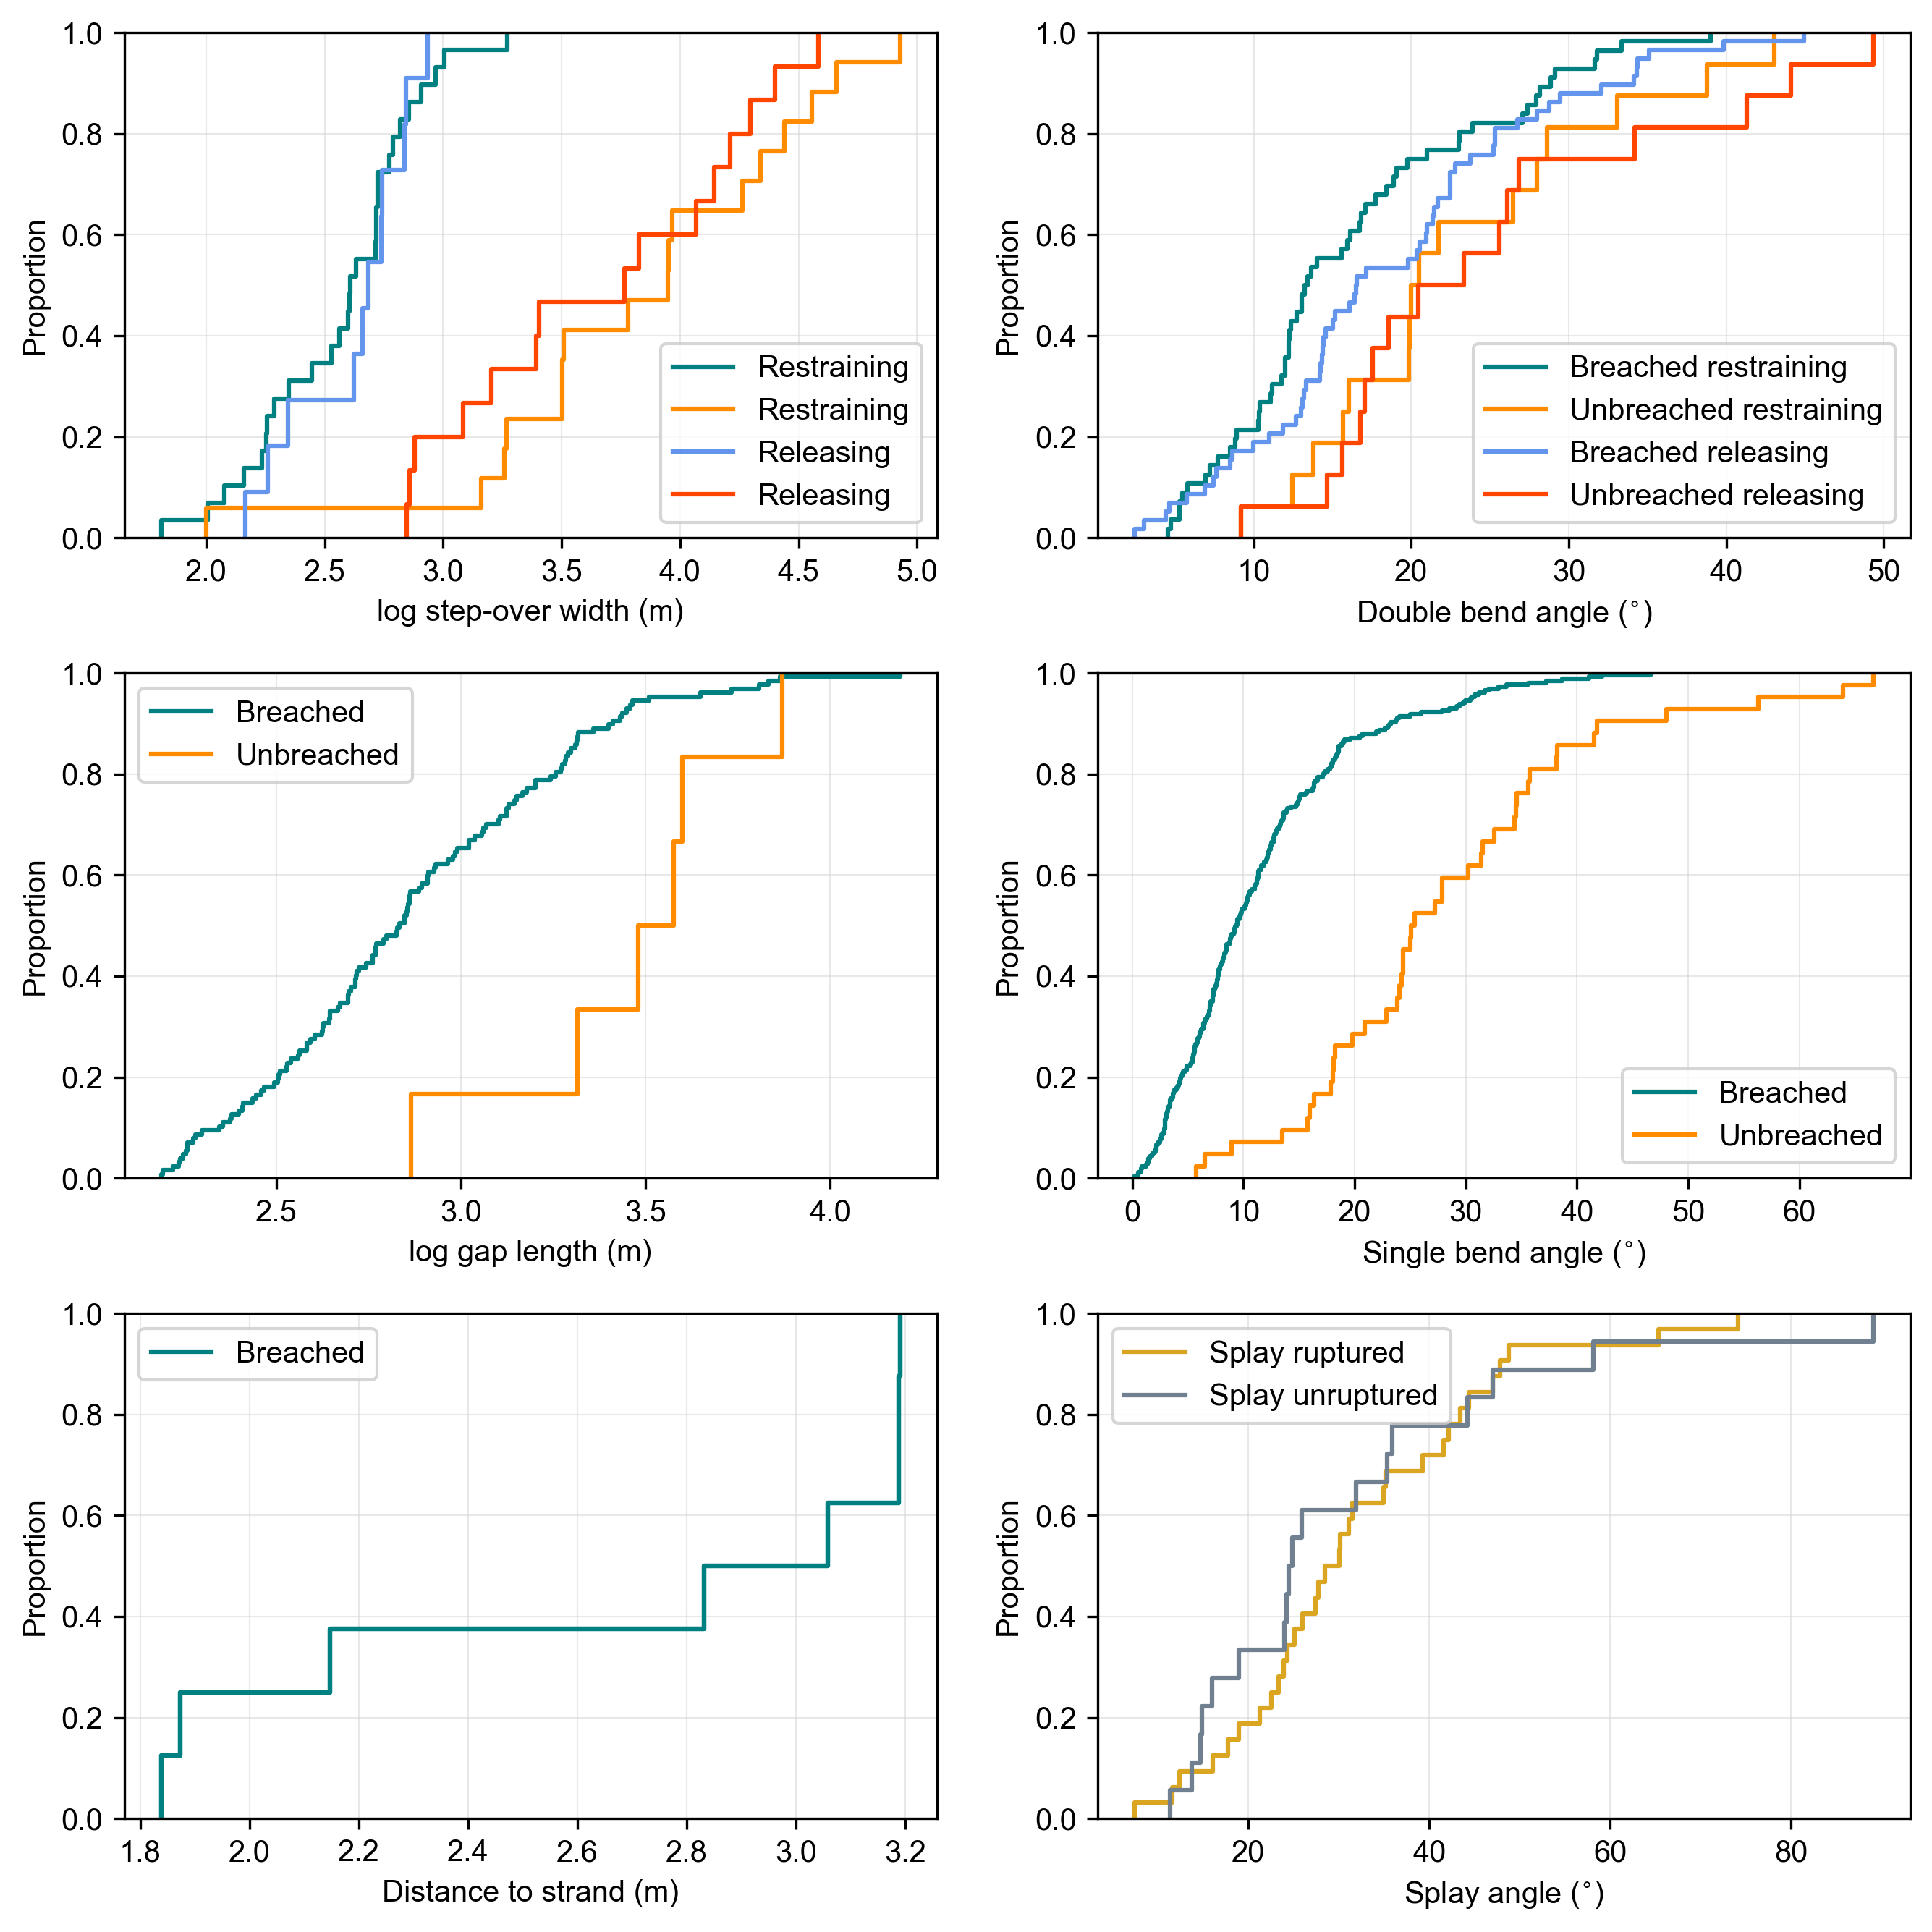

In [5]:
fig, axes = plt.subplots(3,2,figsize=(9,9),dpi=300)
build_cdf(grouped,'stepover', 'restraining', 'length', 'teal','darkorange',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_cdf(grouped,'stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_cdf(grouped,'bend', 'restraining', 'angle','teal','darkorange',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf(grouped,'bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'log gap length (m)','Breached', 'Unbreached')
build_cdf(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/CDFs.pdf')
plt.show()



log-normal distribution fitting

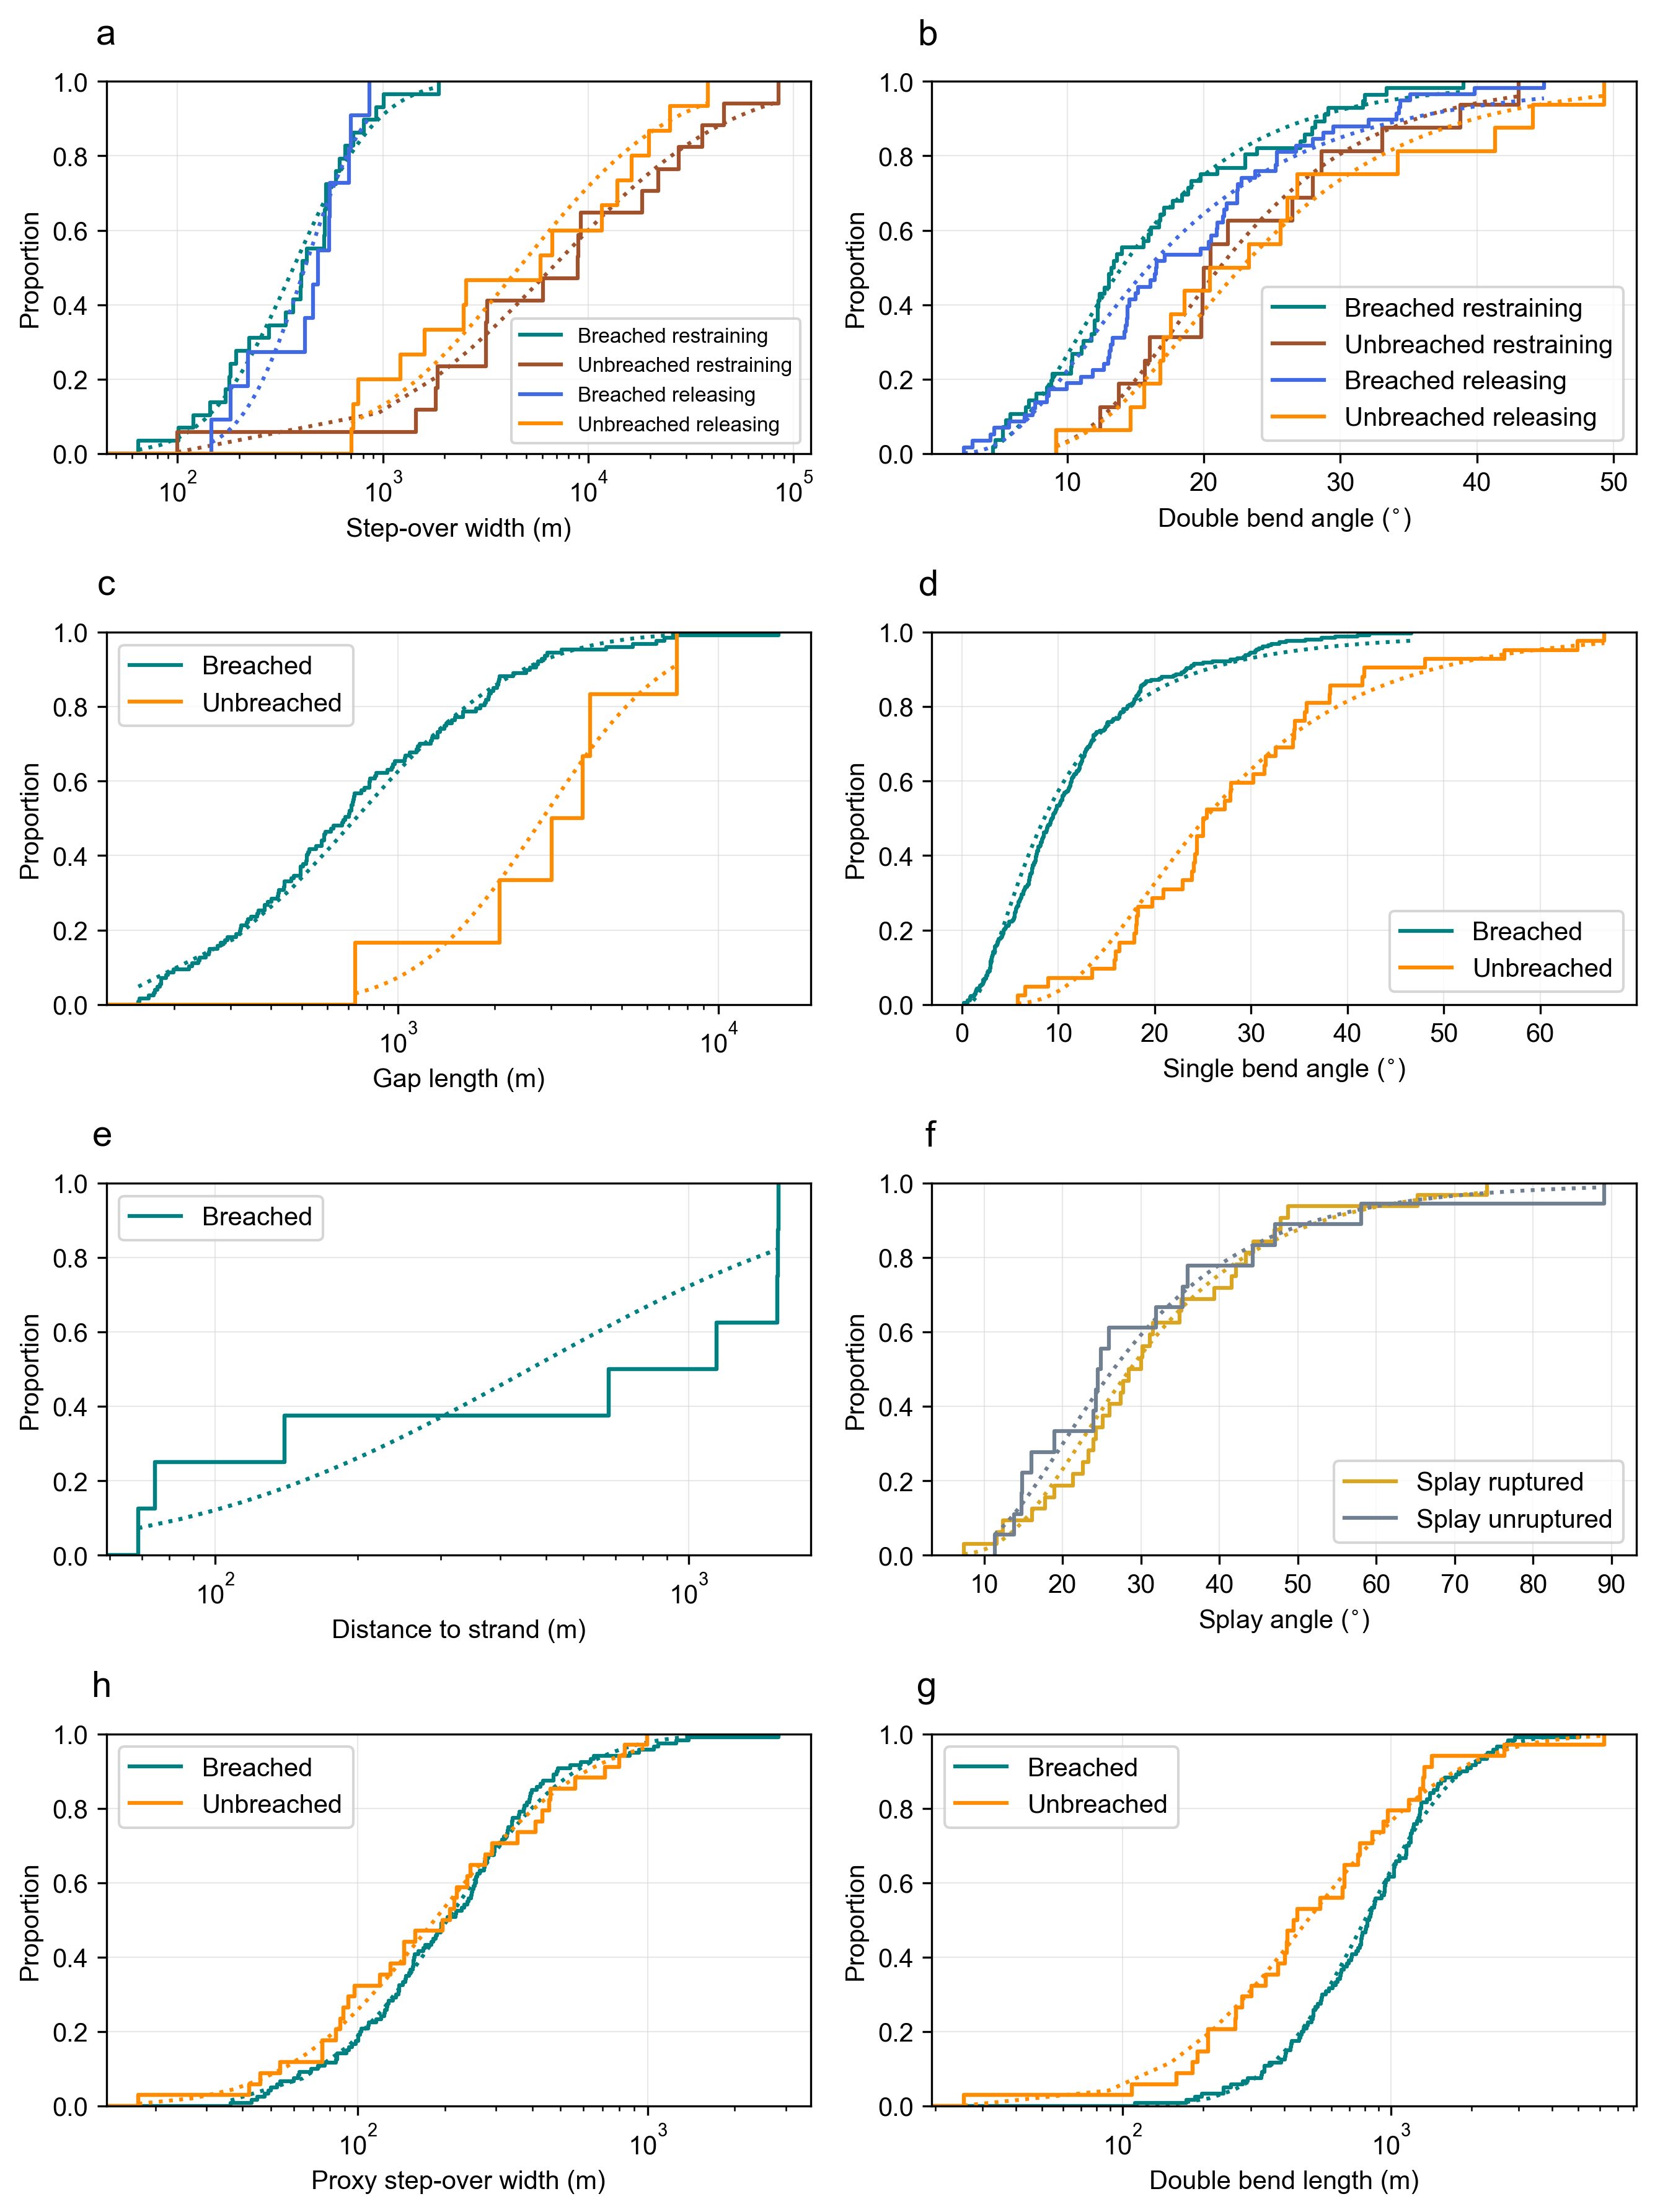

In [6]:
fig, axes = plt.subplots(4,2,figsize=(9,12),dpi=300)

build_cdf_lognorm(grouped,'stepover', 'restraining', 'length', 'teal','sienna',axes[0,0] ,'Step-over width (m)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'stepover', 'releasing', 'length', 'royalblue','darkorange',axes[0,0] , 'Step-over width (m)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'bend', 'restraining', 'angle','teal','sienna',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'bend', 'releasing', 'angle', 'royalblue','darkorange',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'Gap length (m)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf_lognorm(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',axes[3,1],'Double bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',axes[3,0],'Proxy step-over width (m)','Breached', 'Unbreached')

# add labels
axes[0,0].text(40,1.1,'a',fontsize=14)
axes[0,1].text(-1,1.1,'b',fontsize=14)
axes[1,0].text(115,1.1,'c',fontsize=14)
axes[1,1].text(-4.5,1.1,'d',fontsize=14)
axes[2,0].text(55,1.1,'e',fontsize=14)
axes[2,1].text(2.5,1.1,'f',fontsize=14)
axes[3,1].text(17,1.1,'g',fontsize=14)
axes[3,0].text(12,1.1,'h',fontsize=14)

plt.tight_layout()
plt.savefig('GRL/lognorm_CDFs.pdf')
plt.show()


PDFs

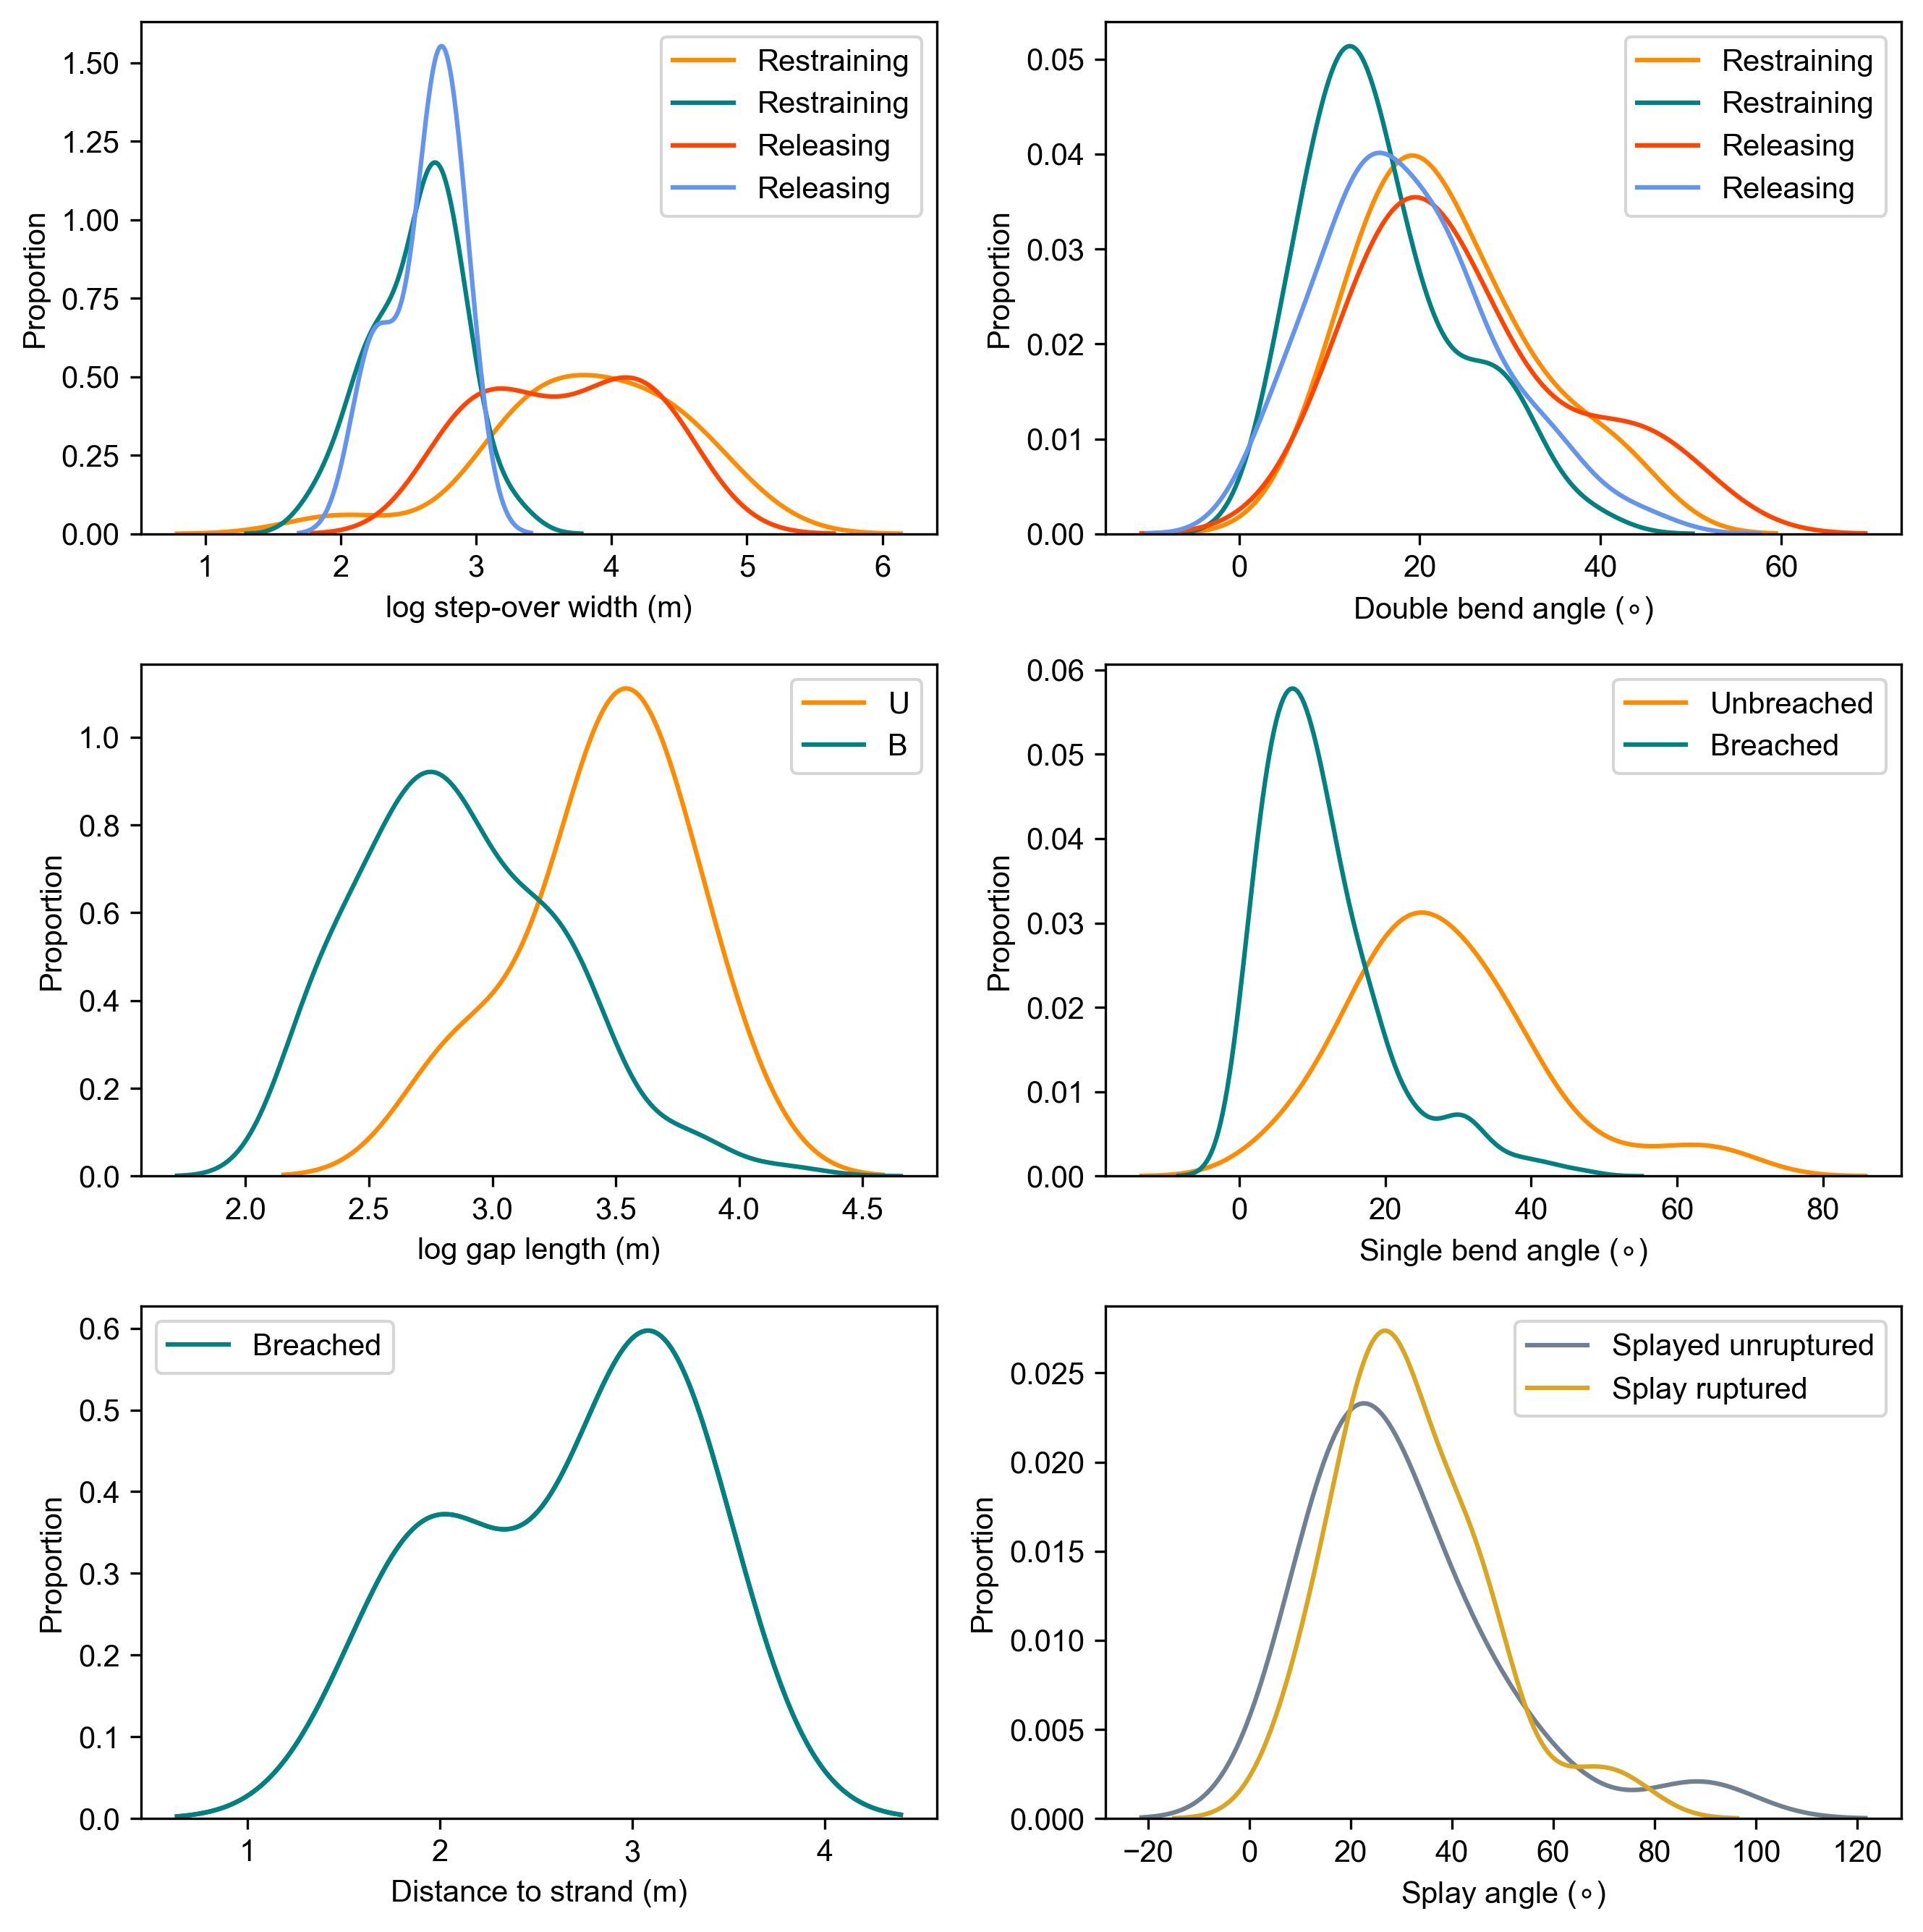

In [7]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_pdf(grouped,'stepover', 'restraining', 'length', 'teal','darkorange',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_pdf(grouped,'stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_pdf(grouped,'bend', 'restraining', 'angle','teal','darkorange',axes[0,1] ,'Double bend angle ($\circ$)','Restraining', 'Restraining')
build_pdf(grouped,'bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($\circ$)','Releasing', 'Releasing')
build_pdf(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'log gap length (m)','B', 'U')
build_pdf(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($\circ$)','Breached', 'Unbreached')
build_pdf(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($\circ$)','Splay ruptured', 'Splayed unruptured')
build_pdf(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/PDFs.pdf')
plt.show()



ks tests

In [8]:
# ks test for populations of earthquake gates
double_bend_ks = kstest_variables(grouped,'bend', 'double', 'angle')
print('double_bend_ks')
print(double_bend_ks)

single_bend_ks = kstest_variables(grouped,'bend', 'single', 'angle')
print('single_bend_ks')
print(single_bend_ks)

stepover_ks= kstest_variables(grouped,'stepover', 'none', 'length')
print('stepover_ks')
print(stepover_ks)

gap_ks = kstest_variables(grouped,'gap', '', 'length')
print('gap_ks')
print(gap_ks)

splay_ks = kstest_variables(grouped,'splay', 'none', 'angle')
print('splay_ks')
print(splay_ks)

releasing_restraining_unbreached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_unbreached', 'angle')
print('releasing_restraining_unbreached_bend_ks')
print(releasing_restraining_unbreached_bend_ks)

releasing_restraining_breached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_breached', 'angle')
print('releasing_restraining_breached_bend_ks')
print(releasing_restraining_breached_bend_ks)

releasing_restraining_breached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_breached', 'length')
print('releasing_restraining_breached_stepover_ks')
print(releasing_restraining_breached_stepover_ks)

releasing_restraining_unbreached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_unbreached', 'length')
print('releasing_restraining_unbreached_stepover_ks')
print(releasing_restraining_unbreached_stepover_ks)


double_bend_ks
KstestResult(statistic=0.3573529411764706, pvalue=0.0015358073533229381, statistic_location=14.5462313088188, statistic_sign=1)
single_bend_ks
KstestResult(statistic=0.6712988697424495, pvalue=2.7910623284464875e-16, statistic_location=15.6935103227513, statistic_sign=1)
stepover_ks
KstestResult(statistic=0.85, pvalue=1.0728630571026729e-13, statistic_location=3.0036662138676324, statistic_sign=1)
gap_ks
KstestResult(statistic=0.7073490813648294, pvalue=0.0023124842492852436, statistic_location=3.3156138688628625, statistic_sign=1)
splay_ks
KstestResult(statistic=0.2361111111111111, pvalue=0.45805022819526797, statistic_location=25.8837228358785, statistic_sign=-1)
releasing_restraining_unbreached_bend_ks
KstestResult(statistic=0.125, pvalue=0.9998909696588173, statistic_location=18.5685515277188, statistic_sign=1)
releasing_restraining_breached_bend_ks
KstestResult(statistic=0.24322660098522167, pvalue=0.05510726311568657, statistic_location=14.0183033402183, statistic_

# Plot passing probabilities and earthquake gate analysis

Logistic models

In [9]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_logistic_regression(
    grouped,
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_logistic_regression(grouped,'bend', 'double', 'angle',None,axes[0,1],0,90,'slategrey','Double bend angle ($^{\circ}$)',2.5)
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_logistic_regression(grouped,'bend', 'single', 'angle', None,
                                                                                                                                                                           axes[1,1],0,90,'slategrey','Single bend angle ($^{\circ}$)',2.5)

log_gap, acc_gap, pre_gap, f1_gap, roc_gap, confusion_matrix_gap, BUbin_gap,xgap = build_logistic_regression(grouped,'gap', 'none', 'length', None, axes[1,0],50,100000,'slategrey','Gap length (m)',3)


# add labels
axes[0,0].text(50,-0.3,'a',fontsize=14)
axes[0,1].text(0,-0.3,'b',fontsize=14)
axes[1,0].text(50,-0.3,'c',fontsize=14)
axes[1,1].text(0,-0.3,'d',fontsize=14)

plt.tight_layout()
plt.savefig('GRL/PP_EQgates.pdf')
plt.show()

## Histogram of bend angles for debugging check

logistic regression for releasing and restraining subgroups

In [10]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
build_logistic_regression(
    grouped,
    'stepover', 
    'releasing', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

build_logistic_regression(grouped,'bend', 'releasing', 'angle', None,
                         axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',2)
build_logistic_regression(grouped,'bend', 'restraining', 'angle', None, 
                         axes[1,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',1.5)
build_logistic_regression(grouped,'stepover', 'restraining', 'length', None, 
                          axes[1,0],100,100000,'slategrey','Step-over width (m)',3)

axes[0,0].set_title('Releasing step-overs')
axes[0,1].set_title('Releasing bends')
axes[1,1].set_title('Restraining bends')
axes[1,0].set_title('Restraining step-overs')

plt.tight_layout()
plt.savefig('GRL/PP_EQgates_RR_categories.pdf')
plt.show()

Predict probability for earthquake gate of given geometry based on logistic model for that type of earthquake gate

In [11]:
x = np.atleast_2d(25).T
#x = np.atleast_2d(np.log10(13000)).T
proba = log_bend_double.predict_proba(x)[:,0]
proba

array([0.72313942])

Let's assess the quality of the logistic regressions. 

In [12]:
print("ROC step-over",roc_stepover)
print("ROC single bend",roc_bend_single)
print("ROC double bend",roc_bend_double)
print("ROC gap",roc_gap)

ROC step-over 0.953125
ROC single bend 0.8759496016305355
ROC double bend 0.691421568627451
ROC gap 0.8805774278215224


### double bend/step-over proxy analysis

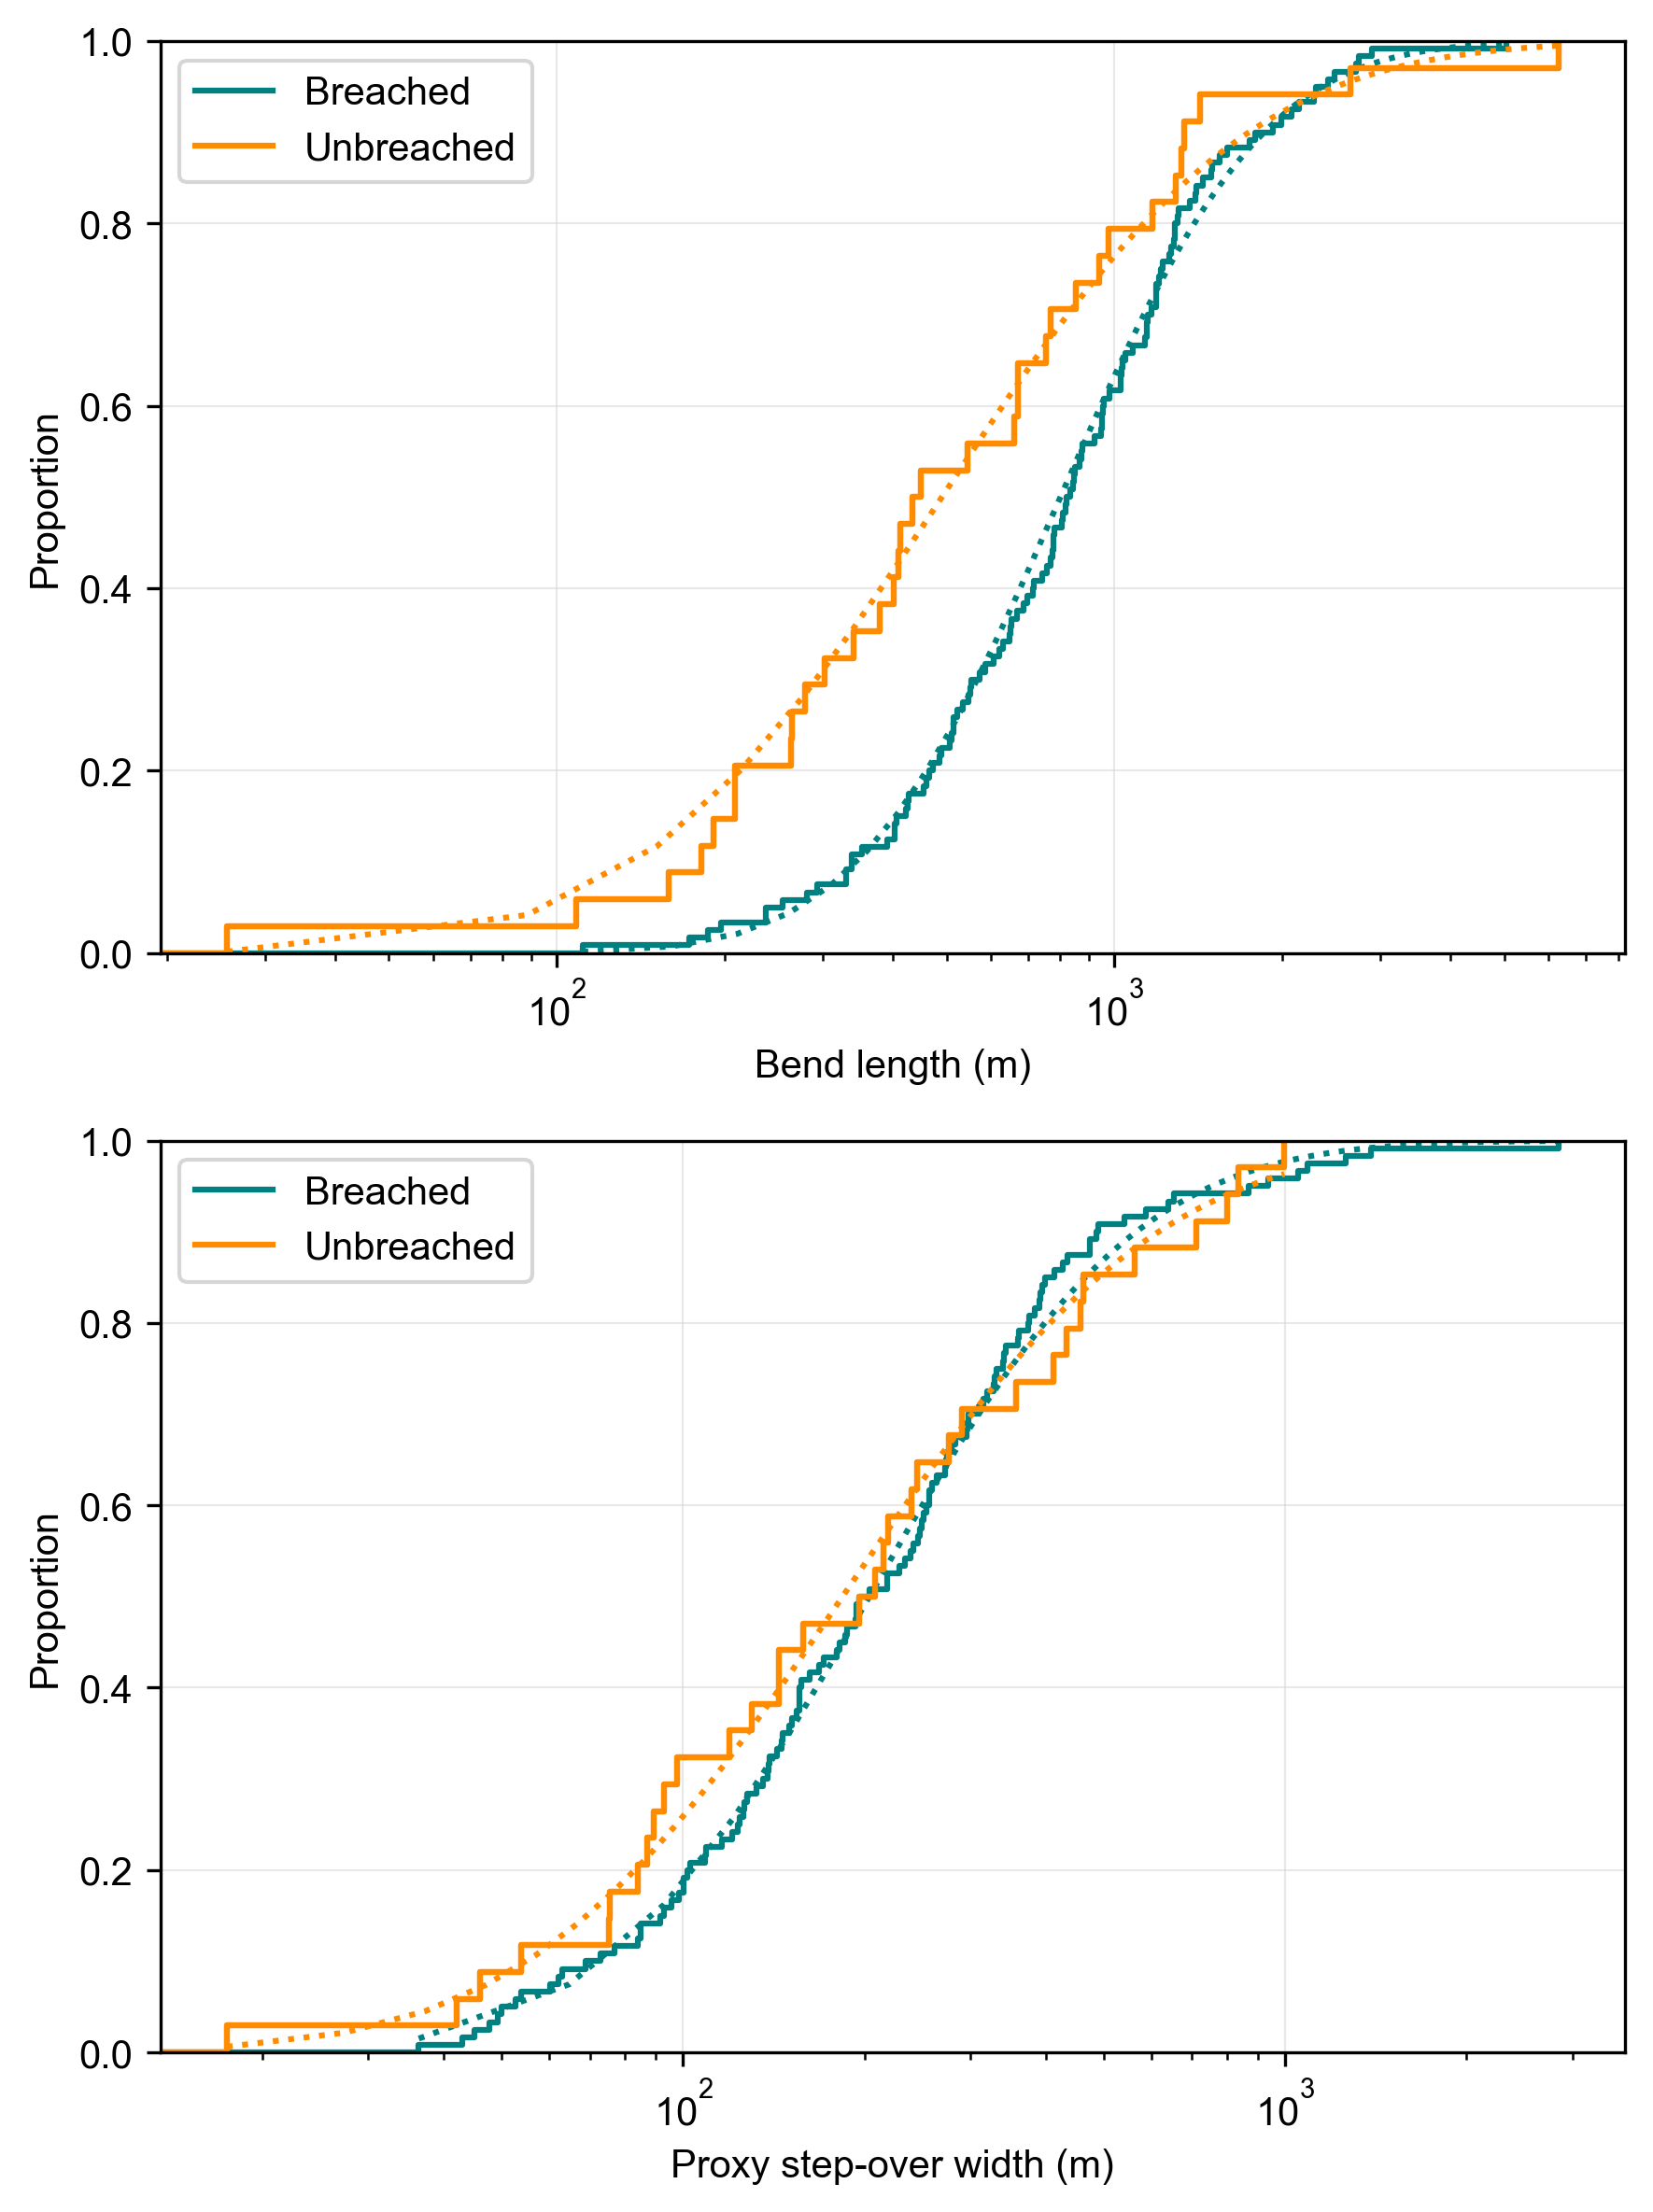

In [13]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',ax[0],'Bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',ax[1],'Proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/bend_length_CDFs.pdf')

In [14]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_regression_double_bend_length(grouped,'bend', 'double', 'Distance splay or double bend (m)',ax[0],50,10000,'log bend length (m)',5)
build_regression_double_bend_length(grouped,'bend', 'double', 'Spacing double bend (m)',ax[1],10,4000,'log proxy step-over width (m)',5)
plt.tight_layout()
plt.savefig('GRL/bend_lengths.pdf.pdf')

Confusion matrices to evaluate logistic model fit

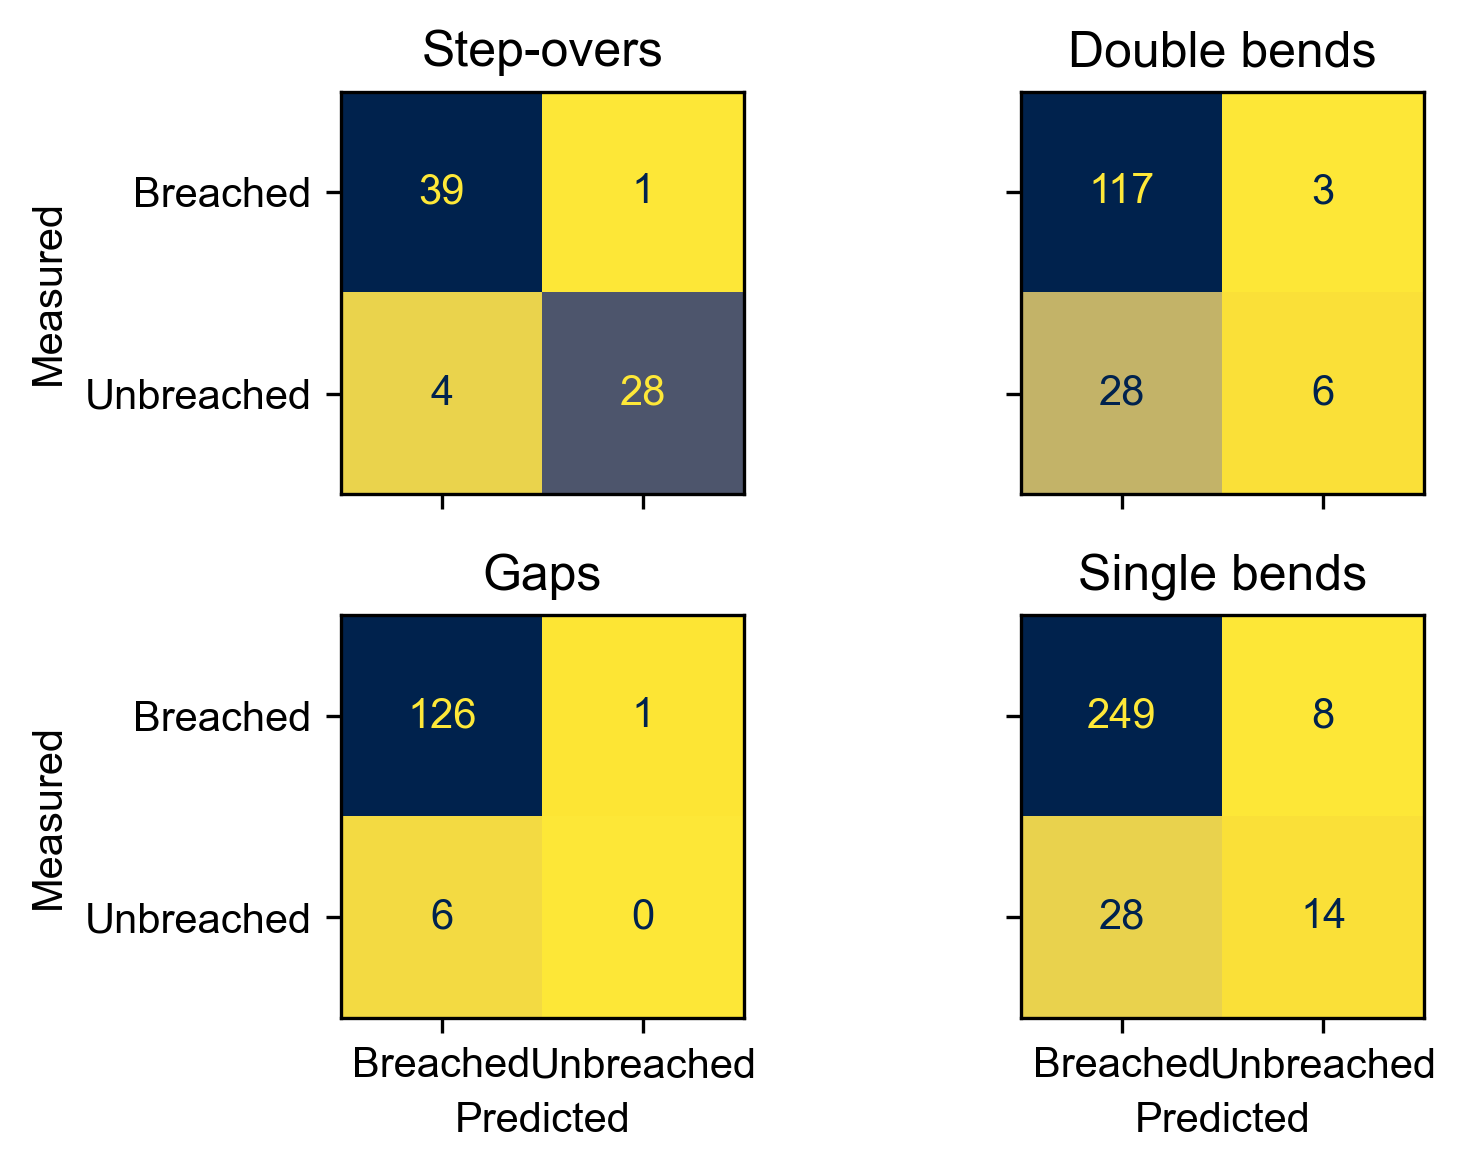

In [15]:
fig, axes = plt.subplots(2,2,figsize=(6,4), dpi=300,sharex=True,sharey=True)

# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('cividis')
labels = ['Breached', 'Unbreached']
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

disp_stepover = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_stepover,display_labels=labels)
disp_stepover.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,0])
axes[0,0].set_title('Step-overs')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Measured')

disp_double_bend = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_double,display_labels=labels)
disp_double_bend.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,1])
axes[0,1].set_title('Double bends')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

disp_double_single = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_single,display_labels=labels)
disp_double_single.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,1])
axes[1,1].set_title('Single bends')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('')

disp_gap = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gap,display_labels=labels)
disp_gap.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,0])
axes[1,0].set_title('Gaps')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Measured')

plt.tight_layout()
plt.savefig('GRL/confusion_matrices.pdf')
plt.show()


ks tests:

In [16]:
# ks test for determining whether populations are different (statistically)
mpl.rcParams['font.size'] = 14
double_bend_ks = kstest_variables(grouped,'bend', 'single', 'angle')
print(double_bend_ks)
splay_ks = kstest_variables(grouped,'splay', 'none', 'angle')
print(splay_ks)

KstestResult(statistic=0.6712988697424495, pvalue=2.7910623284464875e-16, statistic_location=15.6935103227513, statistic_sign=1)
KstestResult(statistic=0.2361111111111111, pvalue=0.45805022819526797, statistic_location=25.8837228358785, statistic_sign=-1)


Nearest distance between strand and step-over:

In [17]:
strand = grouped.get_group("strand")

bins = np.histogram_bin_edges(strand, bins=5, range=[1,max(strand['Length (m) or angle (deg)'])], weights=None)

sns.histplot(strand,x='Length (m) or angle (deg)',color='burlywood',edgecolor='none',alpha=0.8,label='Strand')
plt.yscale('log')
plt.xlabel('Distance to strand (m)')
plt.savefig('GRL/strand_RR.pdf')
plt.show() 

# Analysis of earthquake likelihood magnitude dependence

Extract passing probability for all mapped gates based on logistic models:
-- Note gaps, splays (statiscally indifferent), and strands are all assigned probabilities of 1 given the do not influence rupture propagation

In [18]:
fun_dict = {
    'log_stepover' : log_stepover,  
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double,
    'log_gap': log_gap
}

PR = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)

        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    # elif featurei == 'gap':
    #     strlog = 'log'
    #     name_select = strlog + '_' + 'gap' 
    #     extract = fun_dict[name_select]
    #     x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
    #     PRi  = extract.predict_proba(np.log10(x))[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = fun_dict[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0]
    
    else:
        PRi = 1
        

    PR.append(PRi)

data['PR'] = PR


Calculate earthquake likelihood for each event based on the previously estimated probabilities for each earthquake gate

In [19]:
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
SRL = np.array([])
cumdisp = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0]
    SRLi = subsetb['Total rupture length']
    SRLi = SRLi.iloc[0]
    cumdisp_i = subsetb['Cumulative displacement']
    cumdisp_i = cumdisp_i.iloc[0]

    subsetb['PR'] = subsetb['PR'].astype(float)
    subsetb['PRlog'] = np.log10(subsetb['PR'])   
    event_likelihood_i = np.sum(subsetb['PRlog'])

    print(mag_i,EQ,event_likelihood_i,SRLi)

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)
    cumdisp = np.append(cumdisp,cumdisp_i)

7.7 Balochistan -3.1494352661181297 199115.277475184
6.63 Borrego -1.5057143865290006 31546.4857015686
6.19 ChalfantValley -0.14355836327323088 14207.5427349576
7.0 Darfield -0.8749808242883804 28896.3939931895
7.9 Denali -3.518911384872161 278702.916265388
7.14 Duzce -1.279157024147138 40018.847231306
6.22 ElmoreRanch -0.13745566606245624 8899.97956202332
5.2 GalwayLake -0.2963850544274023 6900.28452126802
7.13 HectorMine -1.3057757671389754 48174.1492813072
6.4 Hualien -0.45879372587088874 7305.71812073165
6.95 Imperial1940 -0.2073479352278406 60614.751301348
6.53 Imperial1979 -0.4712052837736508 32653.1156479598
7.51 Izmit_Kocaeli -1.185848000837205 121770.934867524
6.5 IzuPeninsula -0.12829240514371842 5501.24642743068
6.9 Kobe -0.253848200117584 10101.7645342178
7.0 Kumamoto -1.0122403924728234 31578.8204966148
7.28 Landers -2.265209414958369 84722.12096402
7.7 Luzon -3.5867639165981196 117824.691193508
6.0 Napa -0.519428660598756 22219.9745137025
7.0 Neftegorsk -0.444577497177196

In [20]:
# probability of stopping on straight segment 
n_ends_no_gates = 12
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

In [21]:
fig, ax= plt.subplots(2,1,figsize=(5,8),dpi=300)
ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

# ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Cumulative displacement',norm=mcolors.LogNorm())
#plt.colorbar(ax=ax[0])

idx = np.where(mag < 6) # remove outliers, i.e., events too small for proper rupture propagation to the surface
ax[0].scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[0].annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

mag_del = np.delete(mag, idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)
# slope, intercept, r_value, p_value, std_err, intercept_stderr
print(all_info.slope,all_info.intercept, all_info.intercept_stderr)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = all_info.slope * x_range + all_info.intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = 10^{(%.2f \pm %.2f) %.2f \pm  %.2f(M_W) }$" % (all_info.intercept,all_info.intercept_stderr,all_info.slope,all_info.stderr),linestyle=':',c='darkorange',linewidth=2)
#ax[0].fill_between(x_range, y_range - std_err, y_range + std_err, alpha=0.2,color='darkorange',label='Standard error')

#ax[0].set_ylim([-5.5, 0.9])
ax[0].set_ylabel('Event log likelihood')
ax[0].set_xlabel('Magnitude')
ax[0].set_ylim([-5.5, 0.9])
ax[0].legend(fontsize=10)

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(all_info.slope,all_info.stderr))
print("b = {:.3f} +/- {:.3f}".format(all_info.intercept, all_info.intercept_stderr))

######################################################## cumulative probability

lastpt = []
keeplikelihood = event_likelihood+np.log10(p_continue_straight)*SRL

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['PR'] = subsetb['PR'].astype(float)

    gatelikelihood = subsetb['PR']
    gateloglikelihood = np.log10(subsetb['PR'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['PR'] if not pd.isnull(row['PR']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log10(merged_df['prob']).cumsum()

    lastpt.append(max(SRL_points))

    # now we plot the data and fit the model:    
    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.25,ax=ax[1]) 

ax[1].scatter(lastpt,keeplikelihood,c='slategrey',alpha=0.7,label='Likelihood at final rupture length',linewidth=1.3)
lastpt = np.array(lastpt)
keeplikelihood = np.array(keeplikelihood)
ax[1].scatter(lastpt[idx],keeplikelihood[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[1].annotate(event_group[i], (lastpt[i], keeplikelihood[i]),fontsize=8)

#ax[1].set_xscale('log')
ax[1].set_ylabel('Cumulative event log likelihood')
ax[1].set_xlabel('Distance along the rupture (m)')
ax[1].set_ylim([-5.5, 0.9])
ax[1].set_xlim([10**3, 400*10**3])

# lastpt = np.delete(lastpt,idx)
# keeplikelihood = np.delete(keeplikelihood,idx)

# # # Fit the data to the power-law function
# popt, pcov = curve_fit(power_law, lastpt, keeplikelihood)

# # # Calculate the errors
# perr = np.sqrt(np.diag(pcov))

# # Print the fitted parameters and errors
# print("a = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
# print("b = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))

all_info = stats.linregress(lastpt,keeplikelihood)
# slope, intercept, r_value, p_value, std_err, intercept_stderr
print("a = {:.3f} +/- {:.3f}".format(all_info.slope,all_info.stderr))
print("b = {:.3f} +/- {:.3f}".format(all_info.intercept, all_info.intercept_stderr))

# Define the x range for the line plot
x_range = np.linspace(min(lastpt), max(lastpt), 100)

# Calculate the y values for the line plot
y_range = all_info.slope * x_range + all_info.intercept

# # Plot the power-law fit
# xfit = np.linspace(min(lastpt),max(lastpt), 1000)
# yfit = power_law(xfit, *popt)
# ax[1].plot(xfit, yfit, label=r"$P_{EQ} = (%.2f \pm %.2f) L^{%.2f \pm  %.2f}$" % (popt[0],perr[0], popt[1],perr[1]),linestyle=':',linewidth=2)

ax[1].plot(x_range, y_range, label=r"$P_{EQ} = 10^{(%.2f \pm %.2f) %.5f \pm  %.5f(L) }$" % (all_info.intercept,all_info.intercept_stderr,all_info.slope,all_info.stderr), linestyle=':',linewidth=2)

ax[1].set_xscale('log')

ax[1].tick_params(axis='x', labelsize=12)

ax[0].text(4.92,1.1,'a',fontsize=14)
ax[1].text(1200,1.1,'b',fontsize=14)

# add Gutenberg-Richter prediction
GR_ratio = np.log10(np.array([1, 0.246, 0.110, 0.062, 0.040, 0.028, 0.020, 0.016, 0.012]))  # from Biasi and Wesnousky, 2021
SRL_GR = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63])  # from Biasi and Wesnousky, 2021
# fit pwl through GR data in Table 1 of Biasi and Wesnousky, 2021
popt, pcov = curve_fit(power_law, SRL_GR*10**3, GR_ratio)
xfit = np.linspace(min(SRL_GR*10**3),max(lastpt), 10000)
yfit = power_law(xfit, *popt)
ax[1].plot(xfit, yfit, label='Gutenberg-Ritcher',linestyle=':',linewidth=2,c='black')

#ax[1].plot(SRL_GR*10**3, GR_ratio, label='Gutenberg-Ritcher', linestyle=':',linewidth=2,c='black')
ax[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('GRL/mag_dependence_CDF_likelihood.pdf')
plt.show()


-1.8673072274655258 11.607829725069532 1.8098450737496947
a = -1.867 +/- 0.264
b = 11.608 +/- 1.810
a = -0.000 +/- 0.000
b = -0.252 +/- 0.126


[2.23185355 1.00448148]


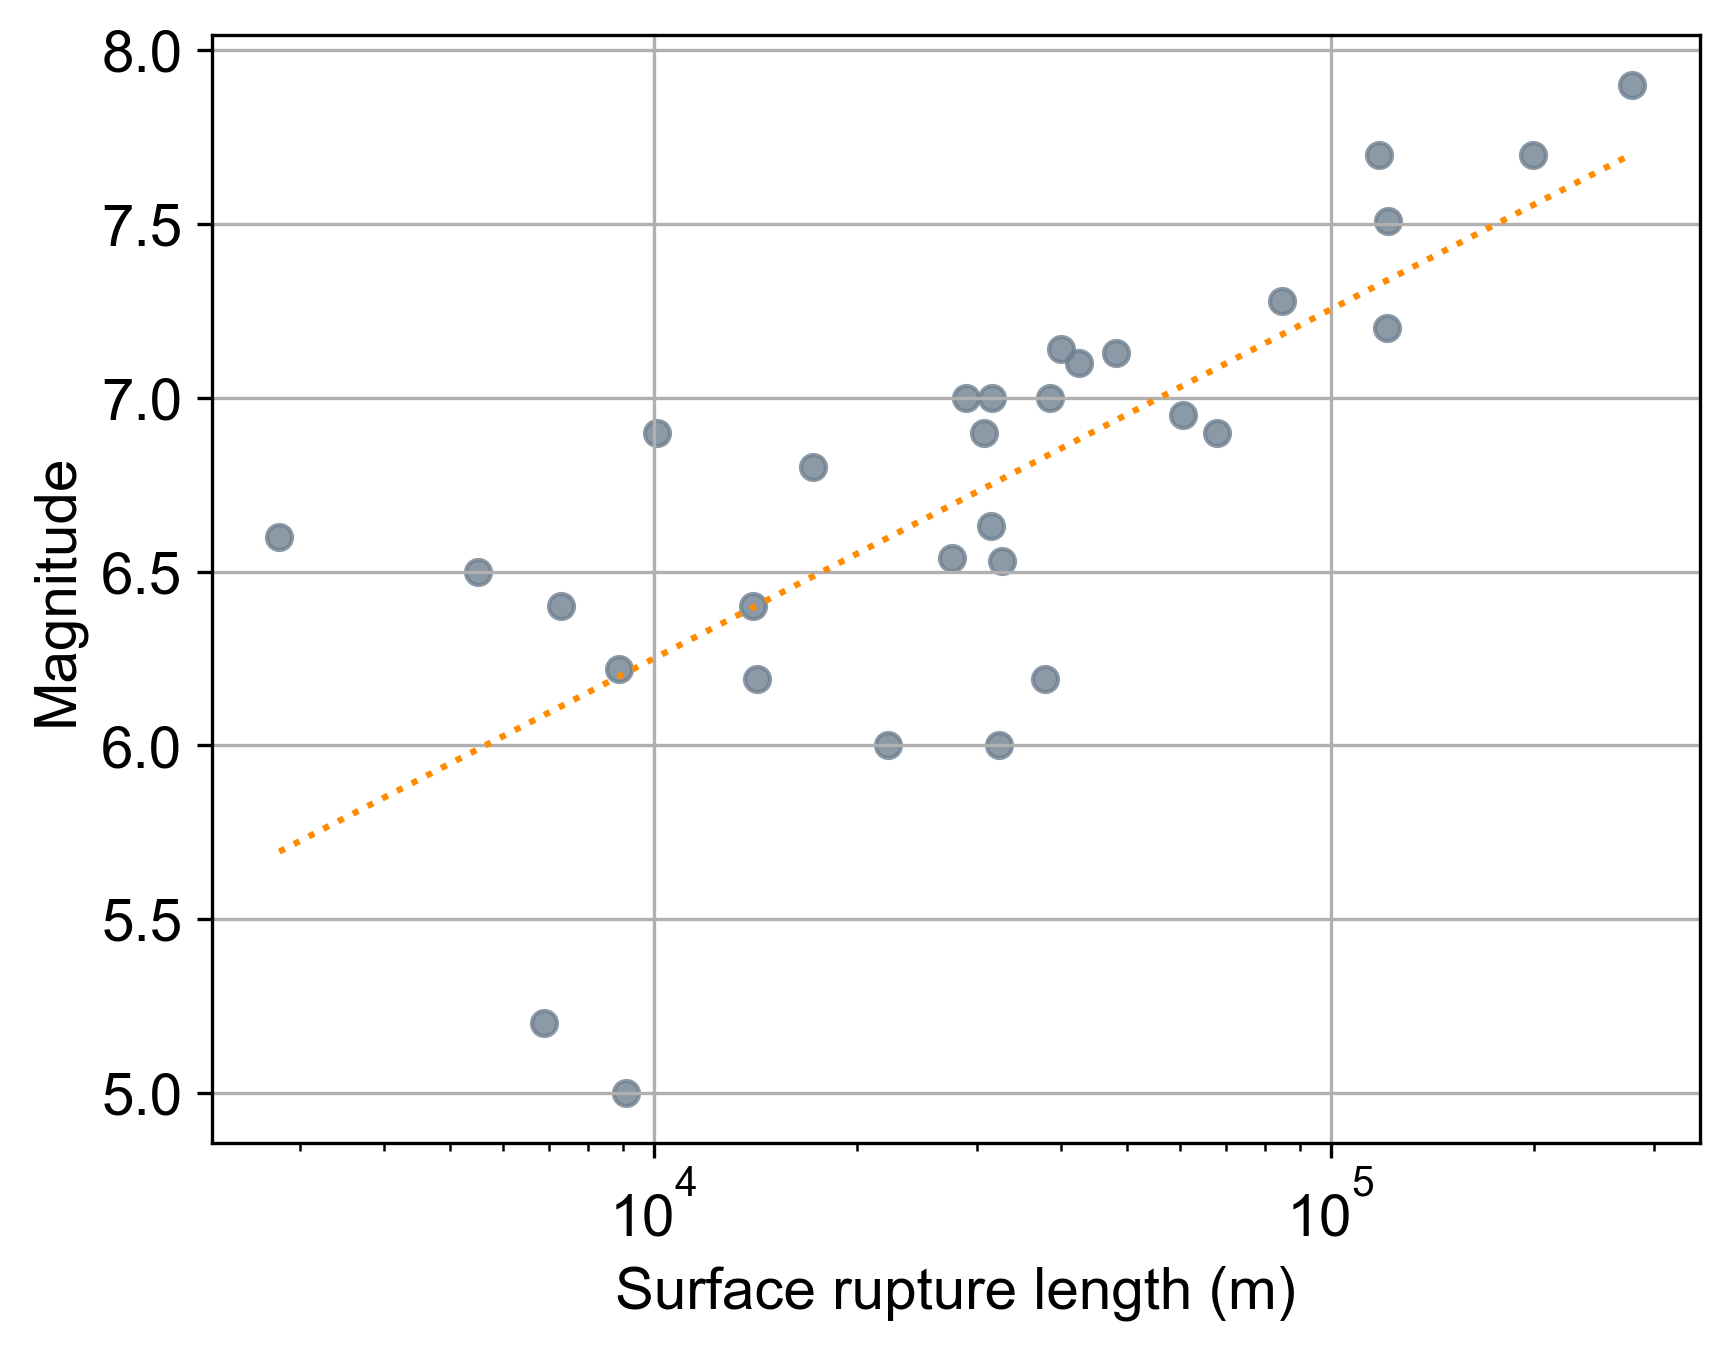

In [22]:
# for each event find magnitude and surface rupture length
plt.figure()
plt.scatter(SRL,mag,color='slategrey',alpha=0.8)
plt.xlabel('Surface rupture length (m)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.grid()


def power_law(x, a, b):
     return b*np.log10(x)+a

popt, pcov = curve_fit(power_law, SRL, mag)

xfit = np.linspace(min(SRL),max(SRL), 1000)
yfit = power_law(xfit, *popt)
plt.plot(xfit, yfit,linestyle=':',color='darkorange')

print(popt)


# Earthquake gates along rupture analysis

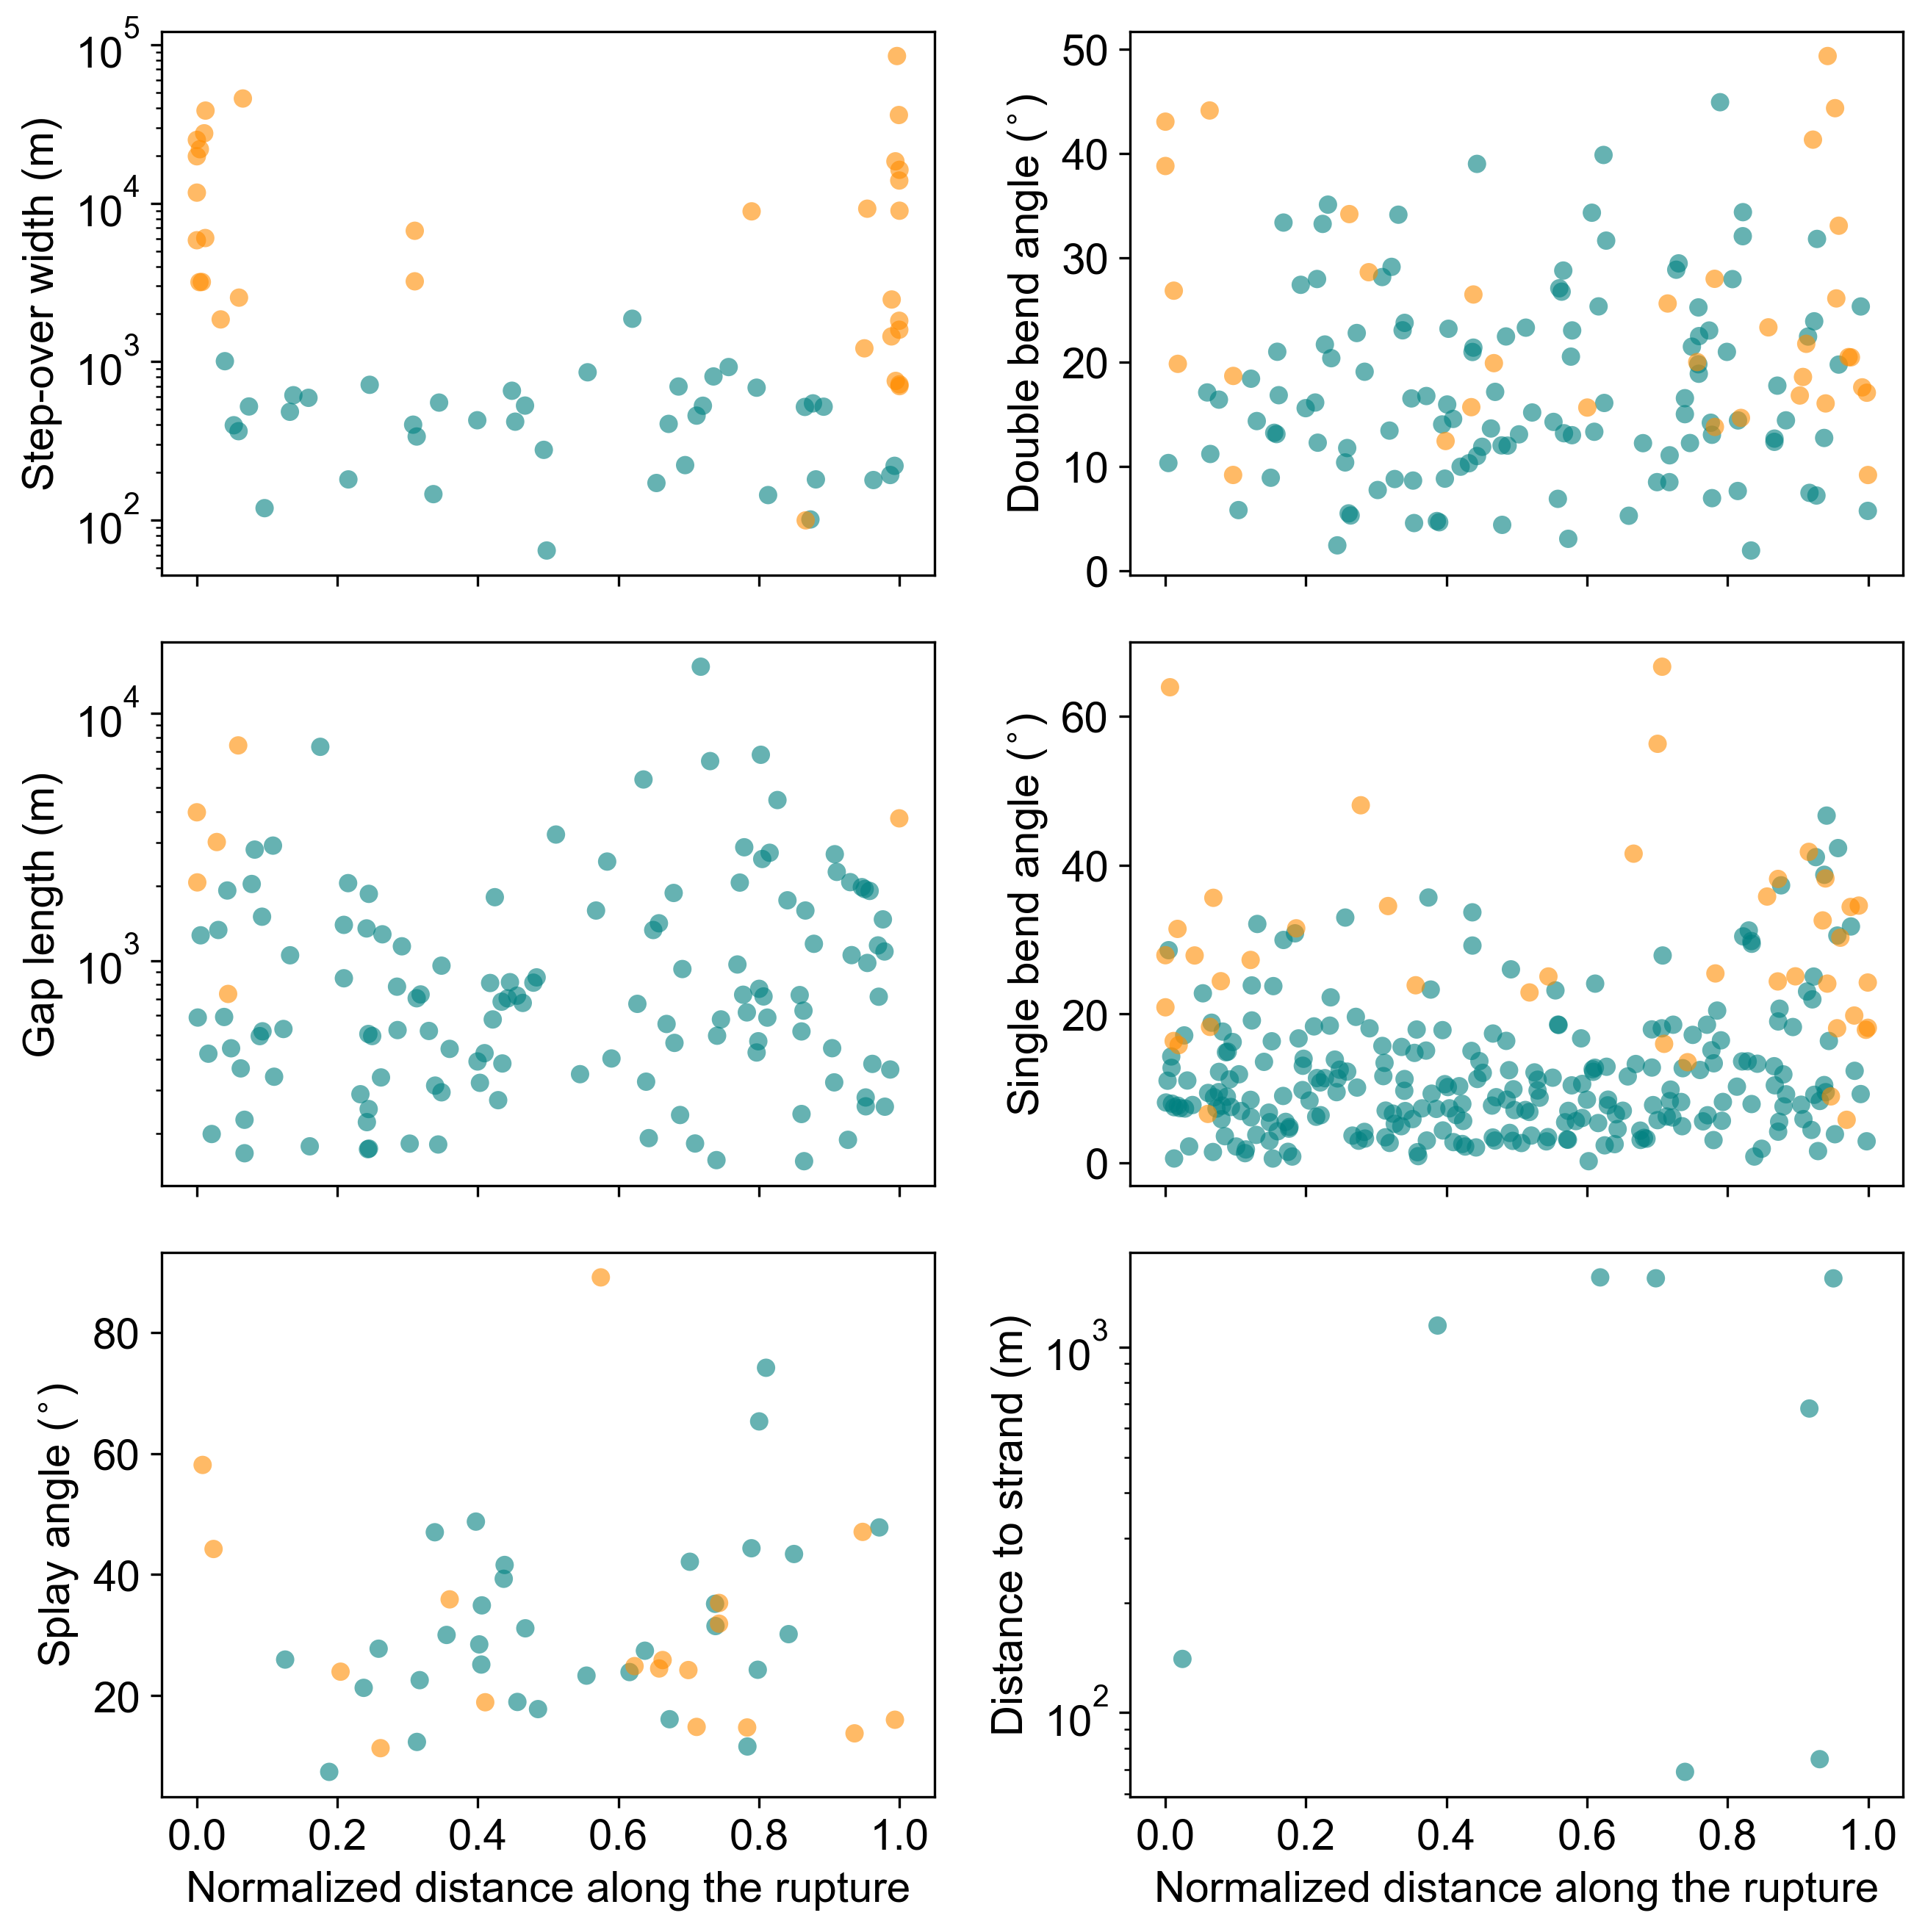

In [23]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike(grouped,'stepover','none','length',axes[0,0],'Step-over width (m)',palette)
gate_distribution_along_strike(grouped,'bend','double','angle',axes[0,1],'Double bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'bend','single','angle',axes[1,1],'Single bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'gap','none','length',axes[1,0],'Gap length (m)',palette)
gate_distribution_along_strike(grouped,'splay','none','angle',axes[2,0],'Splay angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'strand','none','length',axes[2,1],'Distance to strand (m)',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size.pdf')
plt.show()


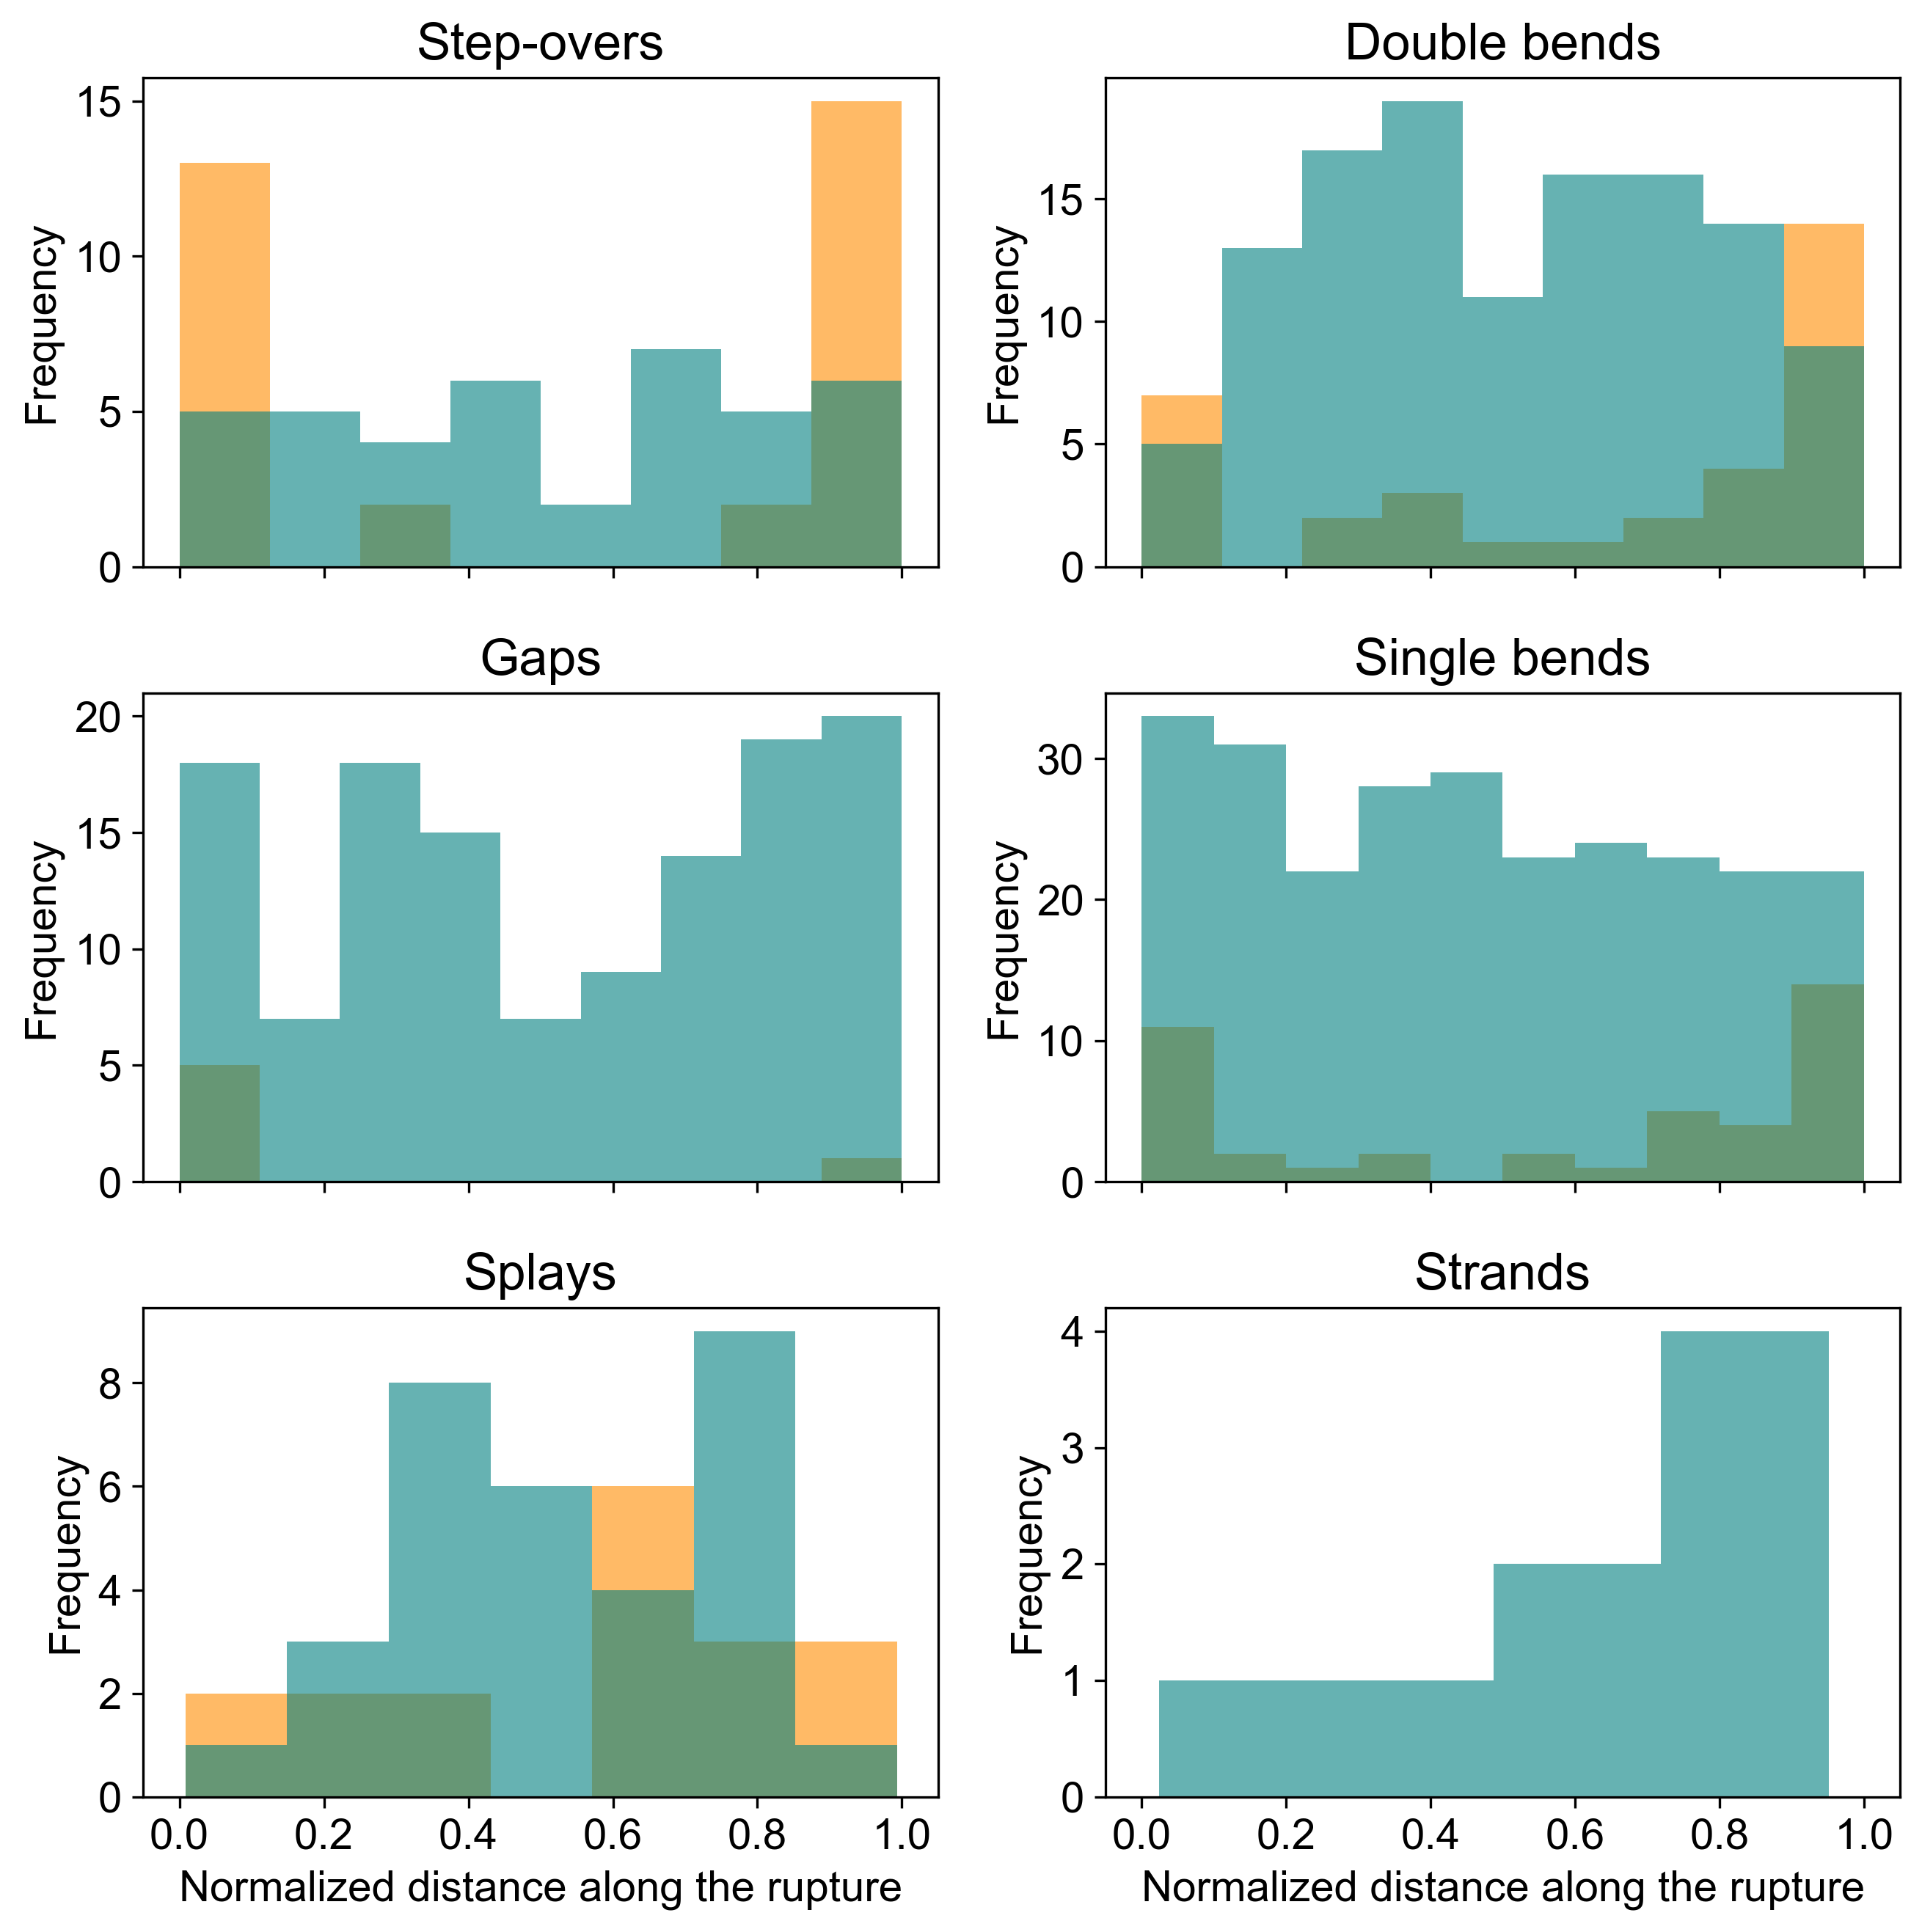

In [24]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike_histogram(grouped,'stepover','none','length',axes[0,0],'Step-overs',palette)
gate_distribution_along_strike_histogram(grouped,'bend','double','angle',axes[0,1],'Double bends',palette)
gate_distribution_along_strike_histogram(grouped,'bend','single','angle',axes[1,1],'Single bends',palette)
gate_distribution_along_strike_histogram(grouped,'gap','none','length',axes[1,0],'Gaps',palette)
gate_distribution_along_strike_histogram(grouped,'splay','none','angle',axes[2,0],'Splays',palette)
gate_distribution_along_strike_histogram(grouped,'strand','none','length',axes[2,1],'Strands',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size_histogram.pdf')
plt.show()

## Comparison to previous studies

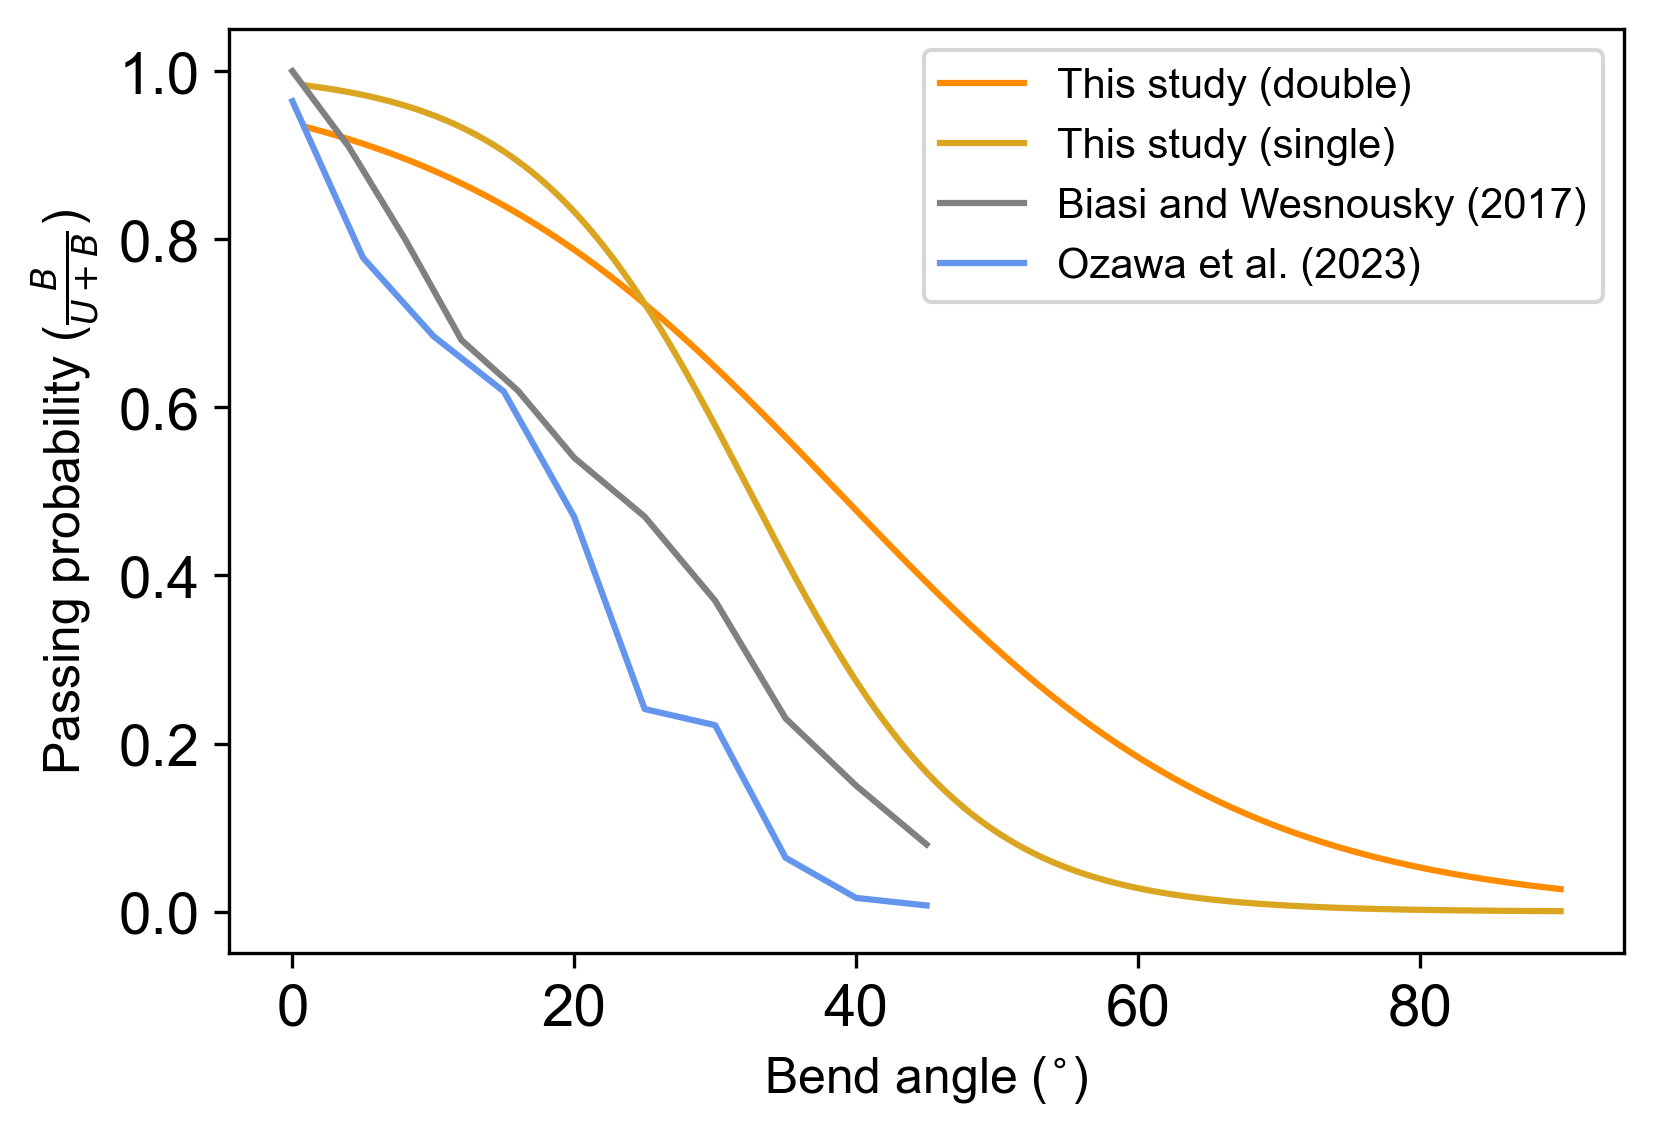

In [25]:
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
double = selectB.get_group('double')
double['Bin'] = pd.cut(double['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
double['Bin Middle'] = double['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = double[double['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = double[double['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)

plt.figure(figsize=(6,4),dpi=300)
#plt.plot(unique_values,ratio,c='darkorange',label='This study (double)')
x = np.atleast_2d(np.linspace(1, 90, 1000)).T
proba_double = log_bend_double.predict_proba(x)[:,0]
proba_single = log_bend_single.predict_proba(x)[:,0]

plt.plot(x,proba_double,c='darkorange',label='This study (double)')
plt.plot(x,proba_single,c='goldenrod',label='This study (single)')
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
single = selectB.get_group('single')
single['Bin'] = pd.cut(single['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
single['Bin Middle'] = single['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = single[single['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = single[single['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)
#plt.plot(unique_values,ratio,c='goldenrod',label='This study (single)')

# load data from Biasi and Wesnousky (2017) and Ozawa et al. (2023)
Bend_angle_Biasi = np.array([0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45])
PP_Biasi = np.array([1, 0.91, 0.80, 0.68, 0.62, 0.54, 0.47, 0.37, 0.23, 0.15, 0.08])

Bend_angle_Ozawa = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
PP_Ozawa = np.array([0.96428571, 0.77829376, 0.68489335, 0.61890165, 0.46959471, 0.24105128, 0.22185883, 0.06410775, 0.01640081, 0.00738151])

plt.plot(Bend_angle_Biasi, PP_Biasi,'gray',label='Biasi and Wesnousky (2017)')
plt.plot(Bend_angle_Ozawa,PP_Ozawa,'cornflowerblue', label='Ozawa et al. (2023)')
plt.ylabel(r'Passing probability ($\frac{B}{U+B}$)',fontsize=12)
plt.xlabel(r'Bend angle ($^{\circ}$)',fontsize=12)
plt.legend(fontsize=10)
plt.savefig('GRL/bendPPcomparisons.pdf')

# Displacement at EQ gate

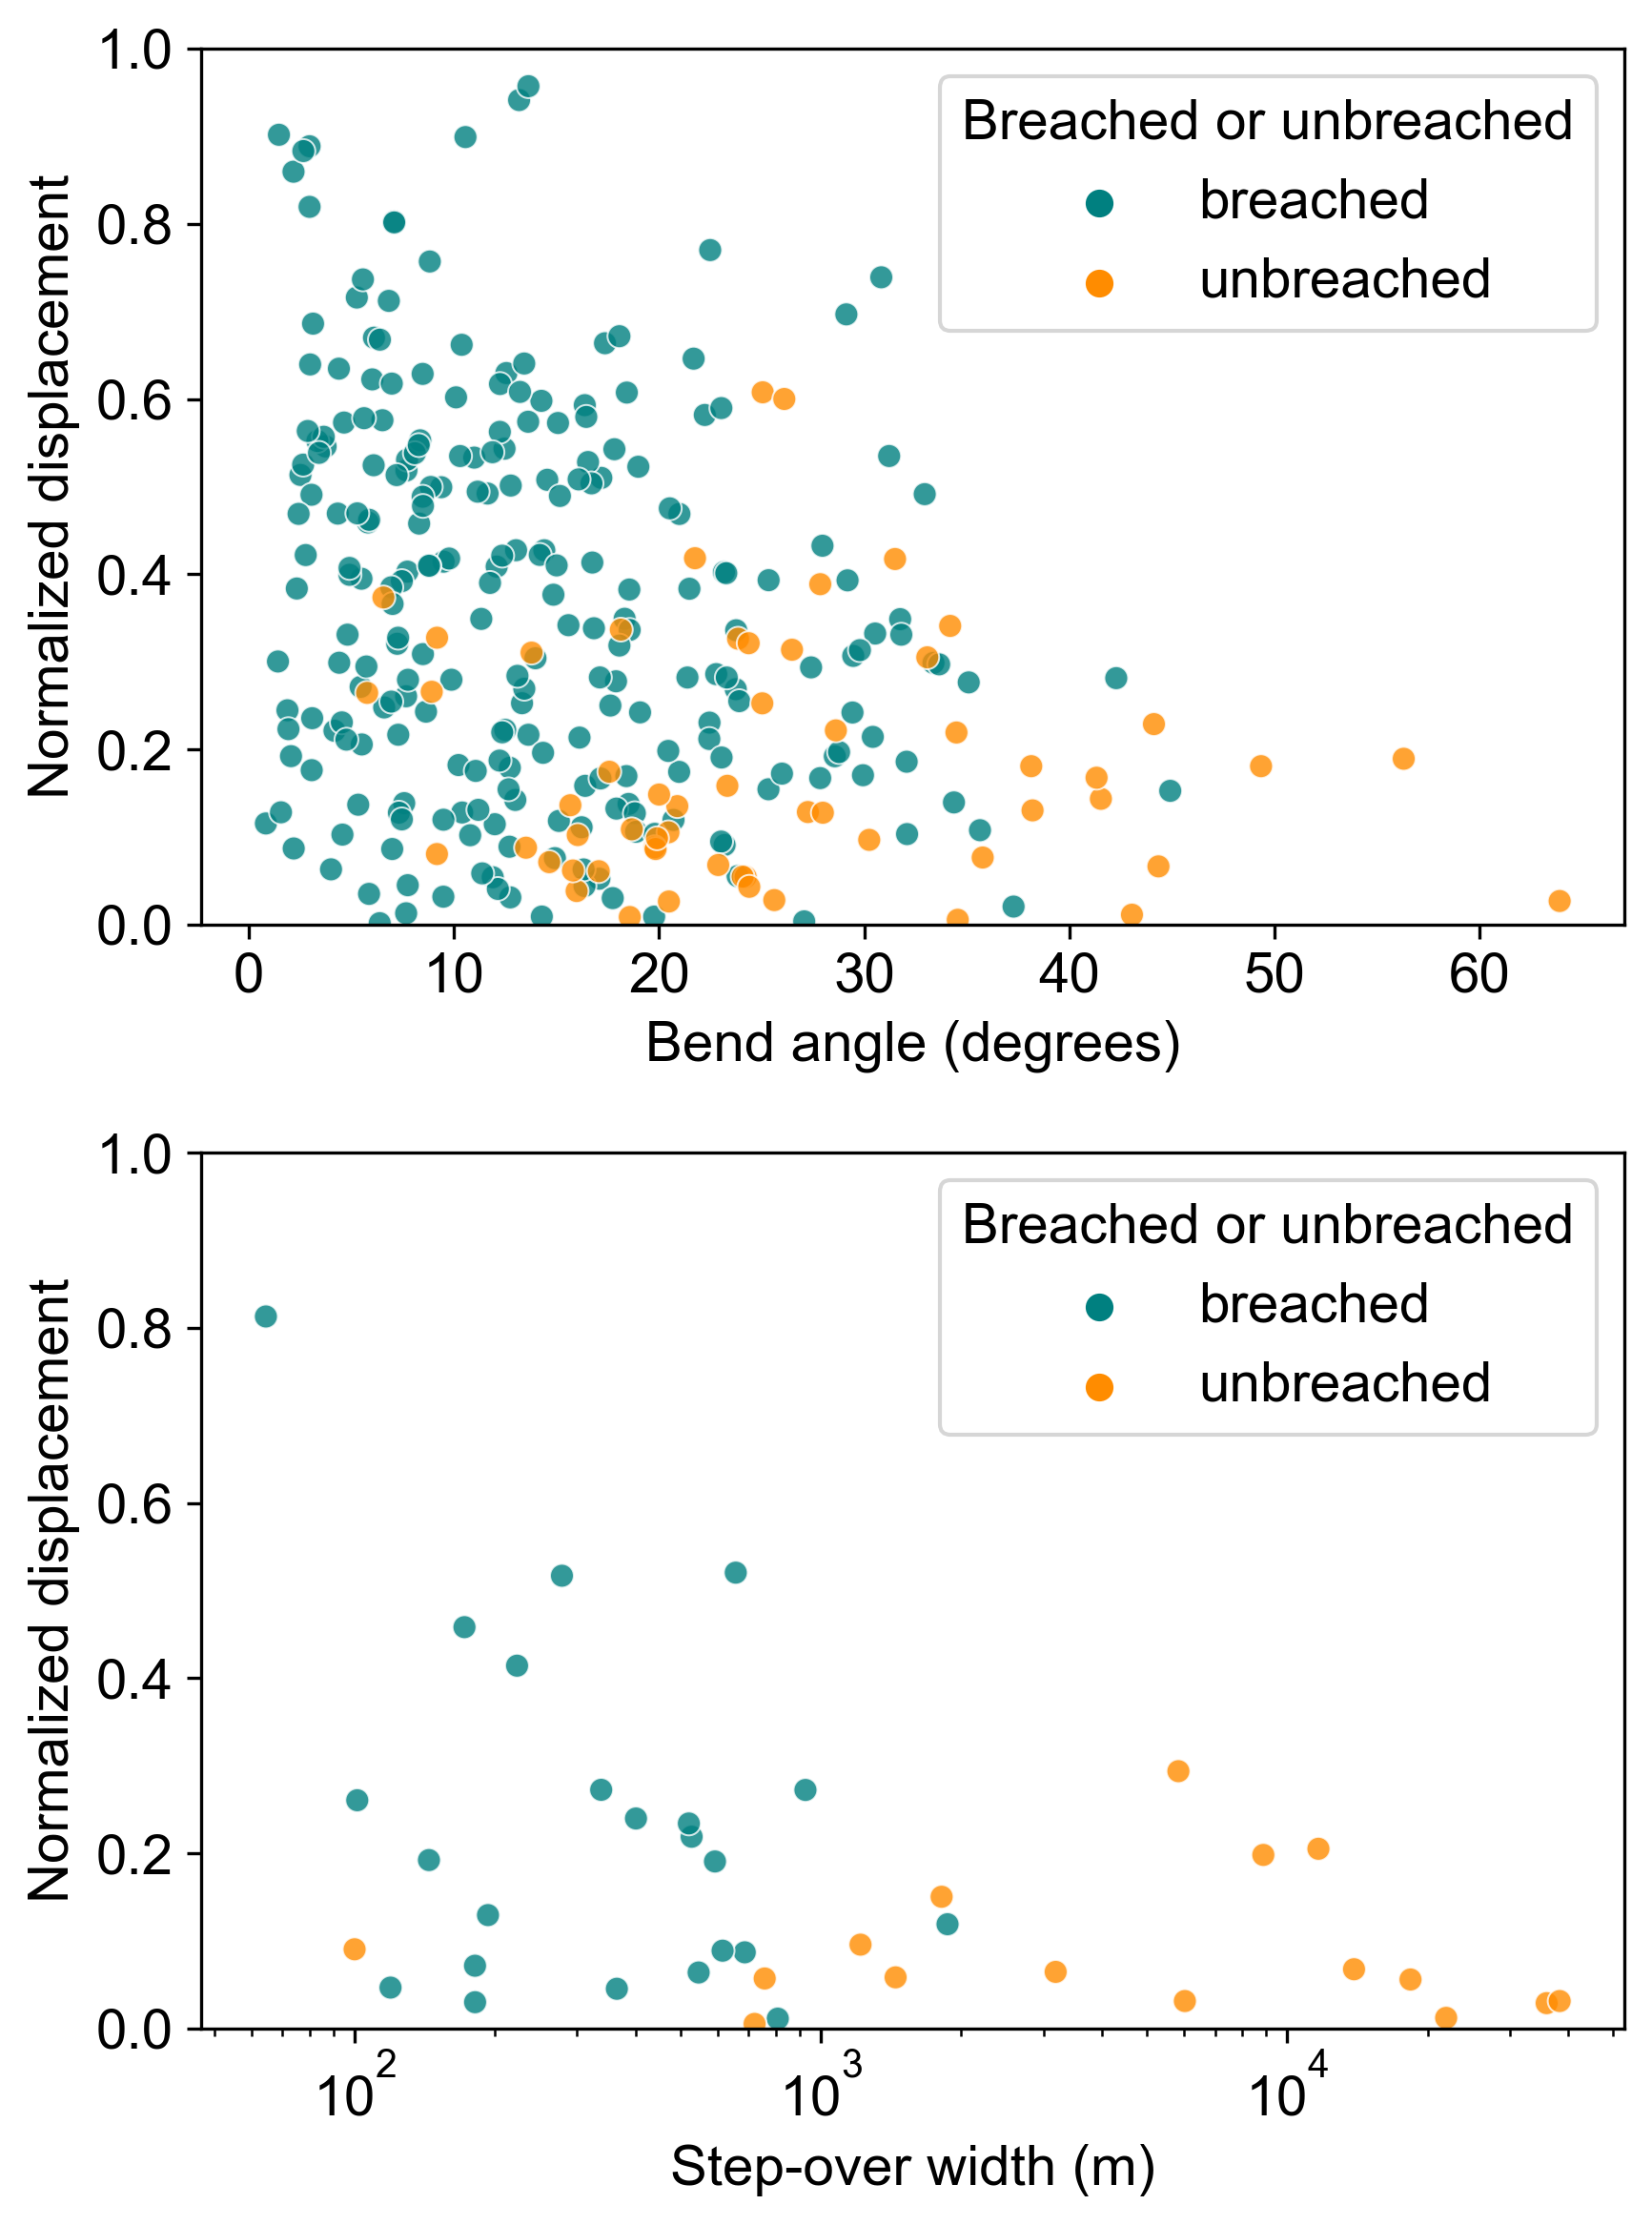

In [26]:
bends = grouped.get_group('bend')
stepovers = grouped.get_group('stepover')

custom_palette = {"breached": "teal", "unbreached": "darkorange"}

fig, axes = plt.subplots(2,1,figsize=(6,8),dpi=300)
sns.scatterplot(data=bends, x='Length (m) or angle (deg)', y='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0])
axes[0].set_xlabel('Bend angle (degrees)')
axes[0].set_ylabel('Normalized displacement')
axes[0].set_ylim(0,1)

sns.scatterplot(data=stepovers, x='Length (m) or angle (deg)', y='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1])
axes[1].set_xlabel('Step-over width (m)')
axes[1].set_xscale('log')
axes[1].set_ylabel('Normalized displacement')
axes[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig('GRL/normalized_slip_at_gate.pdf')